In [112]:
# System management 
import os
import time
import pickle
import dill
from collections import Counter
import gzip
import io

# Data manipulation
import numpy as np
import pandas as pd
import re
pd.options.display.max_rows = 400

# Scikit-learn
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, auc, classification_report
from sklearn.preprocessing import StandardScaler 
from sklearn.feature_selection import RFECV

# Predictive Models
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import lightgbm 
from xgboost import XGBClassifier

# Hyperparameters optimisation
from hyperopt import tpe, hp, fmin, space_eval, STATUS_OK, Trials, SparkTrials
from hyperopt.pyll.base import scope

# Balancing data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

# Interpratability
from lime import lime_tabular
import shap

# MLFlow tracking
import mlflow
from mlflow import log_metric, log_param, log_artifacts

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
#import seaborn as sns
plt.style.use('fivethirtyeight')
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':25,
     'ytick.labelsize':25,
     'axes.labelsize': 25,
     'legend.fontsize': 25,
     'axes.titlesize':45,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })
%matplotlib inline
sns.set_theme(palette='Set1')

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [113]:
# Set main directory
project_path = '/Users/felipelima/Documents/projets/credit-scoring/'
os.chdir(project_path)

In [114]:
# Load data
with gzip.open('data/processed/train_feature_engineering_encoded.csv.gz', 'rb') as file:
    content = file.read()

    data = pd.read_csv(io.StringIO(content.decode('utf-8'))).drop(columns=['SK_ID_CURR'])
data.head()

TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0     1.0                   0            0             0                0   
1     0.0                   0            1             0                1   
2     0.0                   1            0             1                0   
3     0.0                   0            1             0                0   
4     0.0                   0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0             0          202500.0    406597.5      24700.5   
1             0          270000.0   1293502.5      35698.5   
2             0           67500.0    135000.0       6750.0   
3             0          135000.0    312682.5      29686.5   
4             0          121500.0    513000.0      21865.5   

   REGION_POPULATION_RELATIVE  ...  CC_NAME_CONTRACT_STATUS_Signed_MIN  \
0                    0.018800  ...                                 NaN   
1                    0.003542  ...                                 NaN   
2                    0.010030  ...                                 NaN   
3                    0.008020  ...                                 0.0   
4                    0.028660  ...                                 NaN   

   CC_NAME_CONTRACT_STATUS_Signed_MAX  CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
0                                 NaN                                  NaN   
1                                 NaN                                  NaN   
2                                 NaN                                  NaN   
3                                 0.0                                  0.0   
4                                 NaN                                  NaN   

   CC_NAME_CONTRACT_STATUS_Signed_SUM  CC_NAME_CONTRACT_STATUS_Signed_VAR  \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3                                 0.0                                 0.0   
4                                 NaN                                 NaN   

   CC_NAME_CONTRACT_STATUS_nan_MIN  CC_NAME_CONTRACT_STATUS_nan_MAX  \
0                              NaN                              NaN   
1                              NaN                              NaN   
2                              NaN                              NaN   
3                              0.0                              0.0   
4                              NaN                              NaN   

   CC_NAME_CONTRACT_STATUS_nan_MEAN  CC_NAME_CONTRACT_STATUS_nan_SUM  \
0                               NaN                              NaN   
1                               NaN                              NaN   
2                               NaN                              NaN   
3                               0.0                              0.0   
4                               NaN                              NaN   

   CC_NAME_CONTRACT_STATUS_nan_VAR  
0                              NaN  
1                              NaN  
2                              NaN  
3                              0.0  
4                              NaN  

[5 rows x 575 columns]

#### MLFlow 

Set MLFlow tracking

In [115]:
# Create experiment
experiment_name = 'credit_scoring'
# Check if the experiment exists
experiment = mlflow.get_experiment_by_name(experiment_name)
# If the experiment doesn't exist, create it
if experiment is None: 
    mlflow.create_experiment(experiment_name)
# Set the experiment 
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///Users/felipelima/Documents/projets/credit-scoring/mlruns/884488096939595672', creation_time=1700889868350, experiment_id='884488096939595672', last_update_time=1700889868350, lifecycle_stage='active', name='credit_scoring', tags={}>

#### Data pre-processing

In [116]:
# Define training set size
TRAIN_SIZE = 0.8

# Define random state
RANDOM_STATE = 42

##### Missing values

Fill the missing values with a simple imputer

In [117]:
# Check missing values
nan_values = data.isna().sum().sum()
print('Missing values = {} ({:.2%})'.format(nan_values, nan_values/data.size))

inf_values = np.isinf(data).values.sum()
print('Infinite values = {} ({:.2%})'.format(inf_values, inf_values/data.size))

Missing values = 32442135 (18.35%)
Infinite values = 38 (0.00%)


In [118]:
data = data.replace([np.inf, -np.inf], np.nan)

In [119]:
# Define target and features
TARGET = 'TARGET'
target = data[TARGET]
features = data.drop(columns=TARGET)
features_names = data.drop(columns=TARGET).columns.to_list()

In [120]:
# Create imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')

# Fit to data
imp_mean.fit(features)

# Transform data
features_fill = imp_mean.transform(features)
features_fill = pd.DataFrame(features_fill, columns=features_names)

In [121]:
nan_values = features_fill.isna().sum().sum()
print('Missing values = {} ({:.2%})'.format(nan_values, nan_values/data.size))

Missing values = 0 (0.00%)


#### Split data

In [122]:
# Split dataset (filled)
x_train, x_test, y_train, y_test = train_test_split(features_fill, target, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(246004, 574) (246004,)
(61502, 574) (61502,)


#### Data distribution

In [123]:
y_train_counter = Counter(y_train)
y_test_counter = Counter(y_test)
print('Training target statistics:', y_train_counter)
print('Testing target statistics:', y_test_counter)

# Print ratio
print('Ratio is 1:{:.0f} in training/validation set'.format(y_train_counter[0] / y_train_counter[1]))
print('Ratio is 1:{:.0f} in test set'.format(y_test_counter[0] / y_test_counter[1]))

Training target statistics: Counter({0.0: 226154, 1.0: 19850})
Testing target statistics: Counter({0.0: 56527, 1.0: 4975})
Ratio is 1:11 in training/validation set
Ratio is 1:11 in test set


In [124]:
# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.5) # oversample to 1:2 ratio 
under = RandomUnderSampler(sampling_strategy=1) # undersample to 1:1 ratio

# Define pipeline
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
x_res, y_res = pipeline.fit_resample(x_train, y_train)

print('Training target statistics:', Counter(y_res))
print('Ratio is 1:{:.0f} in training/validation set'.format(Counter(y_res)[0] / Counter(y_res)[1]))
print('Validation target statistics:', Counter(y_test))
print('Ratio is 1:{:.0f} in test set'.format(Counter(y_test)[0] / Counter(y_test)[1]))

Training target statistics: Counter({0.0: 113077, 1.0: 113077})
Ratio is 1:1 in training/validation set
Validation target statistics: Counter({0.0: 56527, 1.0: 4975})
Ratio is 1:11 in test set


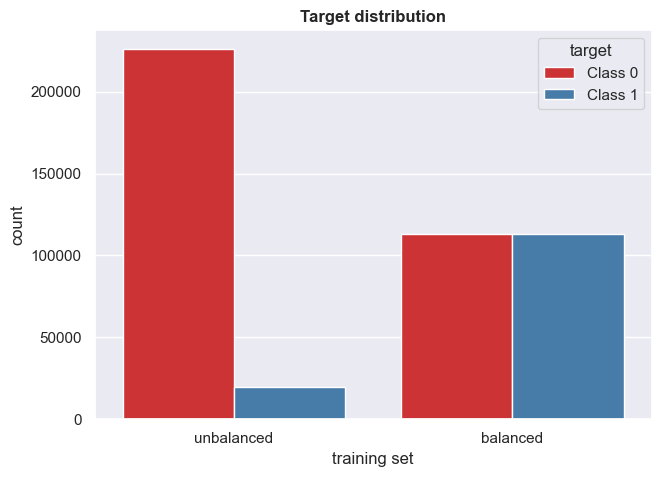

In [125]:
# Display barplot of distribution
class_distr_df = pd.DataFrame({'training set': ['unbalanced', 'unbalanced', 'balanced', 'balanced'],
                               'target': ['Class 0', 'Class 1', 'Class 0', 'Class 1'],
                               'count': [y_train_counter[0], y_train_counter[1], Counter(y_res)[0], Counter(y_res)[1]]})

# Display barplot
sns.barplot(class_distr_df, x='training set', y='count', hue='target')
plt.title('Target distribution')
plt.show()

The resulting data is now balanced. However, since we will test using cross validation, the resampling step shall be done for each cross validation iteration (inside the pipeline).

#### Metric functions

In [126]:
# 1 --> dont repay
# 0 --> repay
# Custom loss function based on business rule =  
# cost FN (dont repay - predicted as repay) = 10 cost FP (repay - predicted as dont repay)
def business_loss_func(y_true, y_pred): # 0 --> best # 1 --> worst
    #beta=10
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    #precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    #recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    #score = ((1 + beta**2) * precision * recall) / ((beta**2 * precision) + recall) if (precision + recall) > 0 else 0

    #cost = (fn + 10 * fp) / (len(y_true))
    #score = 1 - cost

    tn_rate, tp_rate, fp_rate, fn_rate = 1, 1, -1, -10

    total_default = tp + fn
    total_not_default = tn + fp

    total_gain = tn*tn_rate + tp*tp_rate + fp*fp_rate + fn*fn_rate
    min_gain = total_not_default*tn_rate + total_default*fn_rate
    max_gain = total_not_default*tn_rate + total_default*tp_rate

    score = (total_gain - min_gain) / (max_gain - min_gain)

    return score

"""def business_scorer(y_true, y_pred): 
    return business_loss_func(y_true, y_pred)"""

business_scorer = make_scorer(business_loss_func, greater_is_better=True)

def specificity_score_func(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity
specificity_scorer = make_scorer(specificity_score_func, greater_is_better=True)

def false_positive_rate_score_func(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)
    return fpr
fpr_scorer = make_scorer(false_positive_rate_score_func, greater_is_better=False)

#### Classification

In [127]:
def plot_cf_matrix_roc_curve(y_true, y_pred, y_pred_proba, feature_importance=None):
    fig = plt.figure(figsize=(20,15))
    # Left subplot - Confusion Matrix
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    # Right subplot - ROC curve
    plt.subplot(222)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

In [128]:
def train_model(name, model, X=x_train, y=y_train, cv=5, fast_train=None, log=True):
    # Remove special caracters from column name --> lightgbm
    if isinstance(model, LGBMClassifier): 
        X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    # Get only 20% of data for faster train 
    if fast_train is not None: 
        X, _, y, _ = train_test_split(X, y, train_size=fast_train, random_state=RANDOM_STATE, stratify=y)

    # Calculate various evaluation metrics
    results_cv = {}
    results_test = {}

    # Define your scoring metrics
    scoring = {
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'roc_auc': 'roc_auc',
            'specificity': specificity_scorer,
            'fpr': fpr_scorer,
            'business_score': business_scorer
    }

    # Split data into training and validation sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE, stratify=y)

    # Set pipeline with oversampling and undersampling
    pipeline = Pipeline([
                ('over', SMOTE(sampling_strategy=0.5, random_state=RANDOM_STATE)), 
                ('under', RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)), 
                ('classifier', model)
    ])

    # Create a cross-validation generator
    strat_kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    
    # Perform cross-validation with the best model (with or without hyperparameter opt)
    t0 = time.time() 
    scores = cross_validate(pipeline, x_train, y_train, cv=strat_kf, scoring=scoring, n_jobs=-1)
    print(scores)

    # Get train / validation metrics
    for score in scoring.keys():
        results_cv[score] = scores[f'test_{score}'].mean()
    results_cv['fit_time'] = scores['fit_time'].mean()
    results_cv['execution_time'] = time.time() - t0

    # Fit / train with training set
    t0 = time.time()
    pipeline.fit(x_train, y_train)
    results_test['fit_time'] = time.time() - t0

    # Predict on the test set
    y_pred = pipeline.predict(x_test)
    y_pred_proba = pipeline.predict_proba(x_test)[:, 1]

    # Calculate test metrics 
    results_test['accuracy'] = accuracy_score(y_test, y_pred)
    results_test['precision'] = precision_score(y_test, y_pred)
    results_test['recall'] = recall_score(y_test, y_pred)
    results_test['f1'] = f1_score(y_test, y_pred)
    results_test['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
    results_test['specificity'] = specificity_score_func(y_test, y_pred)
    results_test['fpr'] = false_positive_rate_score_func(y_test, y_pred)
    results_test['business_score'] = business_loss_func(y_test, y_pred)
    
    # Plot confusion matrix and roc curve
    plot_cf_matrix_roc_curve(y_test, y_pred, y_pred_proba)

    if log == True: 
    # Save logs
        with mlflow.start_run(run_name=name):
            # Set parameters
            for param, value in model.get_params().items():
                mlflow.log_param(param, value)

            # Set train / validation metrics
            mlflow.log_metric('validation_business_score', results_cv['business_score'])
            mlflow.log_metric('validation_auc', results_cv['roc_auc'])
            mlflow.log_metric('validation_f1', results_test['f1'])
            mlflow.log_metric('validation_accuracy', results_cv['accuracy'])
            mlflow.log_metric('validation_precision', results_cv['precision'])
            mlflow.log_metric('validation_recall', results_cv['recall'])
            mlflow.log_metric('validation_specificity', results_cv['specificity'])
            mlflow.log_metric('validation_false_positive_rate', results_cv['fpr'])
            mlflow.log_metric('validation_fit_time', results_cv['fit_time'])
            mlflow.log_metric('validation_execution_time', results_cv['execution_time'])

            # Set test metrics
            mlflow.log_metric('test_business_score', results_test['business_score'])
            mlflow.log_metric('test_auc', results_test['roc_auc'])
            mlflow.log_metric('test_f1', results_test['f1'])
            mlflow.log_metric('test_accuracy', results_test['accuracy'])
            mlflow.log_metric('test_precision', results_test['precision'])
            mlflow.log_metric('test_recall', results_test['recall'])
            mlflow.log_metric('test_specificity', results_test['specificity'])
            mlflow.log_metric('test_false_positive_rate', results_test['fpr'])
            mlflow.log_metric('test_fit_time', results_test['fit_time'])
            
            # Save model to artifacts
            mlflow.sklearn.log_model(model, name)

    return pipeline, results_cv, results_test

In [129]:
def search_hyperparameters(name, model, X=x_train, y=y_train, cv=5, param_grid=None, fast_train=None, random=True, n_iter=10):
    # Remove special caracters from column name --> lightgbm
    if isinstance(model, LGBMClassifier): 
        X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    # Get only 20% of data for faster train / hyperparameter optmization
    if fast_train is not None: 
        X, _, y, _ = train_test_split(X, y, train_size=fast_train, random_state=RANDOM_STATE)

    # Calculate various evaluation metrics
    results_cv = {}
    results_test = {}

    # Define your scoring metrics
    scoring = {
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'roc_auc': 'roc_auc',
            'specificity': specificity_scorer,
            'fpr': fpr_scorer,
            'business_score': business_scorer
    }

    # Split data into training and validation sets
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

    # Set pipeline with oversampling and undersampling
    pipeline = Pipeline([
                ('over', SMOTE(sampling_strategy=0.5, random_state=RANDOM_STATE)), 
                ('under', RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)), 
                ('classifier', model)
    ])

    # Create a cross-validation generator
    strat_kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)

    # Perform hyperparameter tuning using RandomizedSearchCV or GridSearchCV
    t0 = time.time()
    if random == True:
        grid_searcher = RandomizedSearchCV(pipeline, param_grid, cv=strat_kf, scoring=scoring, n_jobs=-1, random_state=RANDOM_STATE, refit='business_score', verbose=3, n_iter=n_iter)
    else:  
        grid_searcher= GridSearchCV(pipeline, param_grid,  cv=strat_kf, scoring=scoring, n_jobs=-1, refit='business_score', verbose=3)

    grid_searcher.fit(x_train, y_train) 
    best_model = grid_searcher.best_estimator_
    best_params = grid_searcher.best_params_
    best_index = grid_searcher.cv_results_['params'].index(grid_searcher.best_params_)
    for score in scoring.keys():
        results_cv[score] = grid_searcher.cv_results_['mean_test_' + score][best_index]
    results_cv['search_time'] = time.time() - t0

    # Predict on the test set
    y_pred = best_model.predict(x_test)
    y_pred_proba = best_model.predict_proba(x_test)[:, 1]

    # Calculate validation metrics 
    results_test['accuracy'] = accuracy_score(y_test, y_pred)
    results_test['precision'] = precision_score(y_test, y_pred)
    results_test['recall'] = recall_score(y_test, y_pred)
    results_test['f1'] = f1_score(y_test, y_pred)
    results_test['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
    results_test['specificity'] = specificity_score_func(y_test, y_pred)
    results_test['fpr'] = false_positive_rate_score_func(y_test, y_pred)
    results_test['business_score'] = business_loss_func(y_test, y_pred)

    plot_cf_matrix_roc_curve(y_test, y_pred, y_pred_proba)
    
    # Get constant hyperparameters
    model_params = list(model.get_params().keys())
    variable_params = list(param_grid.keys())
    variable_params = [param[len('classifier__'):] for param in variable_params]
    constant_params = [param for param in model_params if param not in variable_params]

    # Start MLFlow run 
    with mlflow.start_run(run_name=name) as parent_run:
        # Loop through each iteration of RandomizedSearchCV
        for i, params in enumerate(grid_searcher.cv_results_['params']):
            with mlflow.start_run(run_name='RandomizedSearchCV_'+str(i), nested=True) as child_run:
                # Set constant parameters
                for param, value in model.get_params().items():
                    if param in constant_params: 
                        mlflow.log_param(param, value)
                # Set variable parameters
                params = {key[len('classifier__'):]: value for key, value in params.items()}
                mlflow.log_params(params)

                # Set validation metrics
                mlflow.log_metric('validation_business_score', grid_searcher.cv_results_['mean_test_business_score'][i])
                mlflow.log_metric('validation_auc', grid_searcher.cv_results_['mean_test_roc_auc'][i])
                mlflow.log_metric('validation_f1', grid_searcher.cv_results_['mean_test_f1'][i])
                mlflow.log_metric('validation_accuracy', grid_searcher.cv_results_['mean_test_accuracy'][i])
                mlflow.log_metric('validation_precision', grid_searcher.cv_results_['mean_test_precision'][i])
                mlflow.log_metric('validation_recall', grid_searcher.cv_results_['mean_test_recall'][i])
                mlflow.log_metric('validation_specificity', grid_searcher.cv_results_['mean_test_specificity'][i])
                mlflow.log_metric('validation_false_positive_rate', grid_searcher.cv_results_['mean_test_fpr'][i])
                mlflow.log_metric('validation_fit_time', grid_searcher.cv_results_['mean_fit_time'][i])
                mlflow.log_metric('validation_score_time', grid_searcher.cv_results_['mean_score_time'][i])

        # Save information for best model
        # Set constant parameters
        for param, value in model.get_params().items():
            if param in constant_params: 
                mlflow.log_param(param, value)
                
        # Set variable parameters
        best_params = {key[len('classifier__'):]: value for key, value in best_params.items()}
        mlflow.log_params(best_params)

        # Set train / validation metrics
        mlflow.log_metric('validation_business_score', results_cv['business_score'])
        mlflow.log_metric('validation_auc', results_cv['roc_auc'])
        mlflow.log_metric('validation_f1', results_test['f1'])
        mlflow.log_metric('validation_accuracy', results_cv['accuracy'])
        mlflow.log_metric('validation_precision', results_cv['precision'])
        mlflow.log_metric('validation_recall', results_cv['recall'])
        mlflow.log_metric('validation_specificity', results_cv['specificity'])
        mlflow.log_metric('validation_false_positive_rate', results_cv['fpr'])
        mlflow.log_metric('search_time', results_cv['search_time'])

        # Set test metrics
        mlflow.log_metric('test_business_score', results_test['business_score'])
        mlflow.log_metric('test_auc', results_test['roc_auc'])
        mlflow.log_metric('test_f1', results_test['f1'])
        mlflow.log_metric('test_accuracy', results_test['accuracy'])
        mlflow.log_metric('test_precision', results_test['precision'])
        mlflow.log_metric('test_recall', results_test['recall'])
        mlflow.log_metric('test_specificity', results_test['specificity'])
        mlflow.log_metric('test_false_positive_rate', results_test['fpr'])

        # Save model to artifacts
        mlflow.sklearn.log_model(best_model, name)

    return best_model, results_cv, results_test


In [130]:
def plot_metrics(results_cv, results_test, metrics): 
    # Create a 2x3 grid of subplots
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Model Metrics Comparison', fontsize=16)

    # Pastel colors
    pastel_colors = ['#FF6666', '#FFCC99', '#99FF99', '#66B2FF', '#C2C2F0', '#999966', '#FF69B4', '#B19CD9']

    # Models to remove x-axis and y-axis labels
    no_x_labels = []#['DummyClassifier', 'LogisticRegression', 'RandomForest']
    no_y_labels = []#['LogisticRegression', 'RandomForest', 'LightGBM', 'CatBoost']

    # Iterate over models and plot metrics
    for i, model in enumerate(results_cv.keys()):
        metrics_dict = results_cv[model]
        test_metrics_dict = results_test[model]
        ax = axs[i // 3, i % 3]

        x = np.arange(len(metrics))
        width = 0.4

        # Train bars
        train_metrics = [metrics_dict[metric] for metric in metrics]
        ax.bar(x - width/2, train_metrics, width, label='Train', color=pastel_colors, alpha=0.7)

        # Test bars
        test_metrics = [test_metrics_dict[metric] for metric in metrics]
        ax.bar(x + width/2, test_metrics, width, label='Test', color='gray', alpha=0.7)

        ax.set_title(model)
        ax.set_xticks(x)
        ax.set_xticklabels(metrics, rotation=45)
        ax.set_ylim(0, 1)

        if model in no_x_labels:
            ax.set_xticklabels([])

        if model in no_y_labels:
            ax.set_yticklabels([])

    # Adjust subplot layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    # Add a legend
    axs[1, 2].legend(loc='upper right')

    # Show the plots
    plt.show()

#### Modelling

For the sake of computation, we will use 20% of the data

##### DummyClassifier (= baseline 0)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs
{'fit_time': array([1.55006003, 1.50146103, 1.50296712, 1.47185802, 1.460181  ]), 'score_time': array([0.03127289, 0.03645015, 0.04005313, 0.02923274, 0.02437782]), 'test_accuracy': array([0.49390244, 0.49237805, 0.49034553, 0.49390244, 0.48869411]), 'test_precision': array([0.07916562, 0.0776577 , 0.07564715, 0.07916562, 0.07413923]), 'test_recall': array([0.49606299, 0.48661417, 0.47401575, 0.49606299, 0.46383648]), 'test_f1': array([0.13654096, 0.13394018, 0.13047248, 0.13654096, 0.12784399]), 'test_roc_auc': array([0.49488793, 0.48974898, 0.48289705, 0.49488793, 0.47735771]), 'test_specificity': array([0.49371286, 0.49288379, 0.49177836, 0.49371286, 0.49087894]), 'test_fpr': array([-0.50628714, -0.50711621, -0.50822164, -0.50628714, -0.50912106]), 'test_business_score': array([-0.55304223, -0.56420902, -0.57909807, -0.55304223, -0.58933676])}


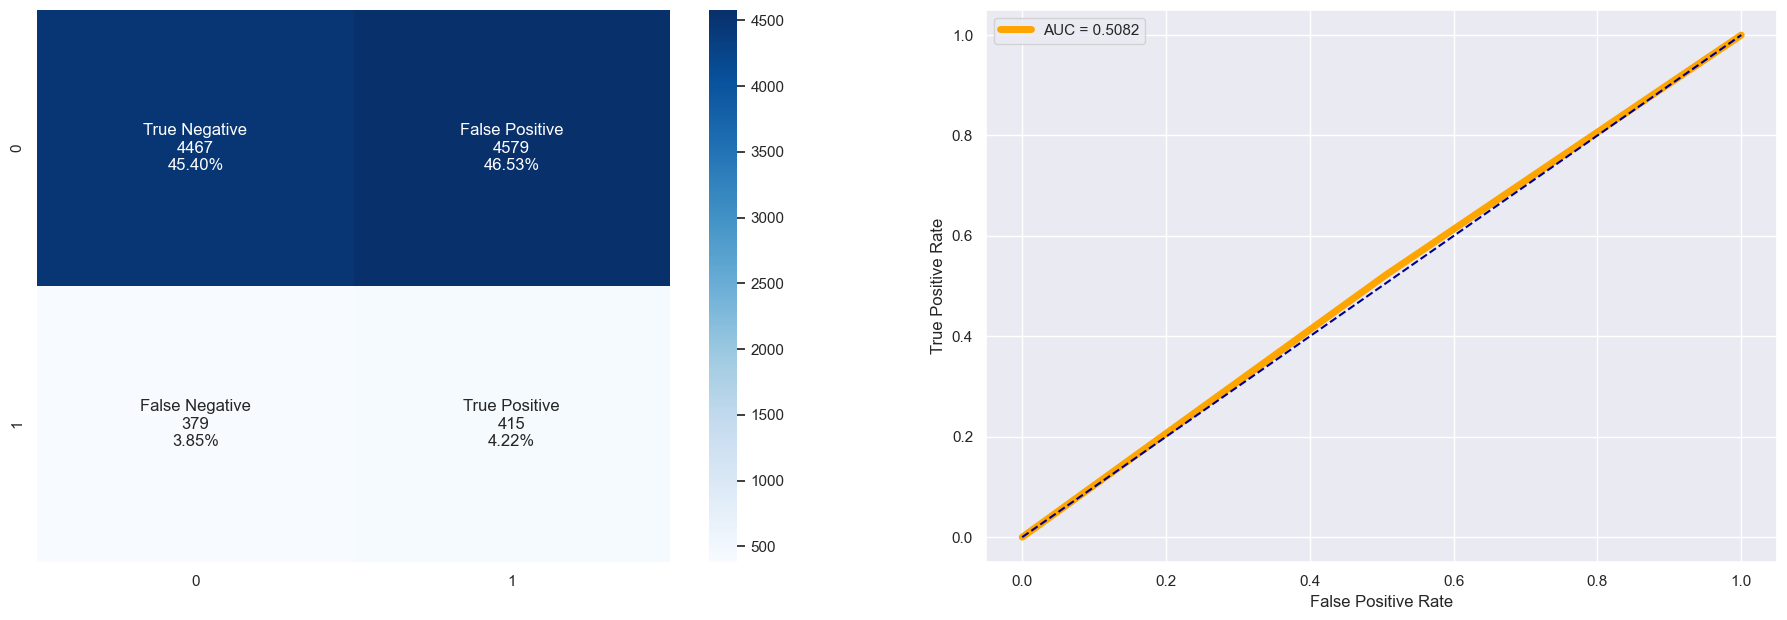

In [24]:
%time
# Create logistic regression model
dc = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dc_name = 'DummyClassifier'

# Compute results 
dc_model, dc_results_cv, dc_results_test = train_model(dc_name, dc, cv=5, fast_train=0.2)

##### Logistical regression (= baseline 1)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

{'fit_time': array([2.9857111 , 2.43459916, 3.60737705, 3.70075321, 3.60306811]), 'score_time': array([0.02559686, 0.0410428 , 0.0708189 , 0.03634572, 0.06445098]), 'test_accuracy': array([0.58854167, 0.86979167, 0.44893293, 0.49174289, 0.55500508]), 'test_precision': array([0.09337914, 0.10685484, 0.09405832, 0.09659636, 0.09676512]), 'test_recall': array([0.47086614, 0.08346457, 0.67559055, 0.63464567, 0.5408805 ]), 'test_f1': array([0.15585093, 0.09372237, 0.16512702, 0.16767214, 0.1641613 ]), 'test_roc_auc': array([0.56214314, 0.54764024, 0.5757593 , 0.58124381, 0.57743341]), 'test_specificity': array([0.59886693, 0.93878679, 0.42904518, 0.47920409, 0.55624655]), 'test_fpr': array([-0.40113307, -0.06121321, -0.57095482, -0.52079591, -0.44375345]), 'test_business_score': array([-0.36034359, -0.04337867, -0.50751611, -0.44452398, -0.37707261])}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


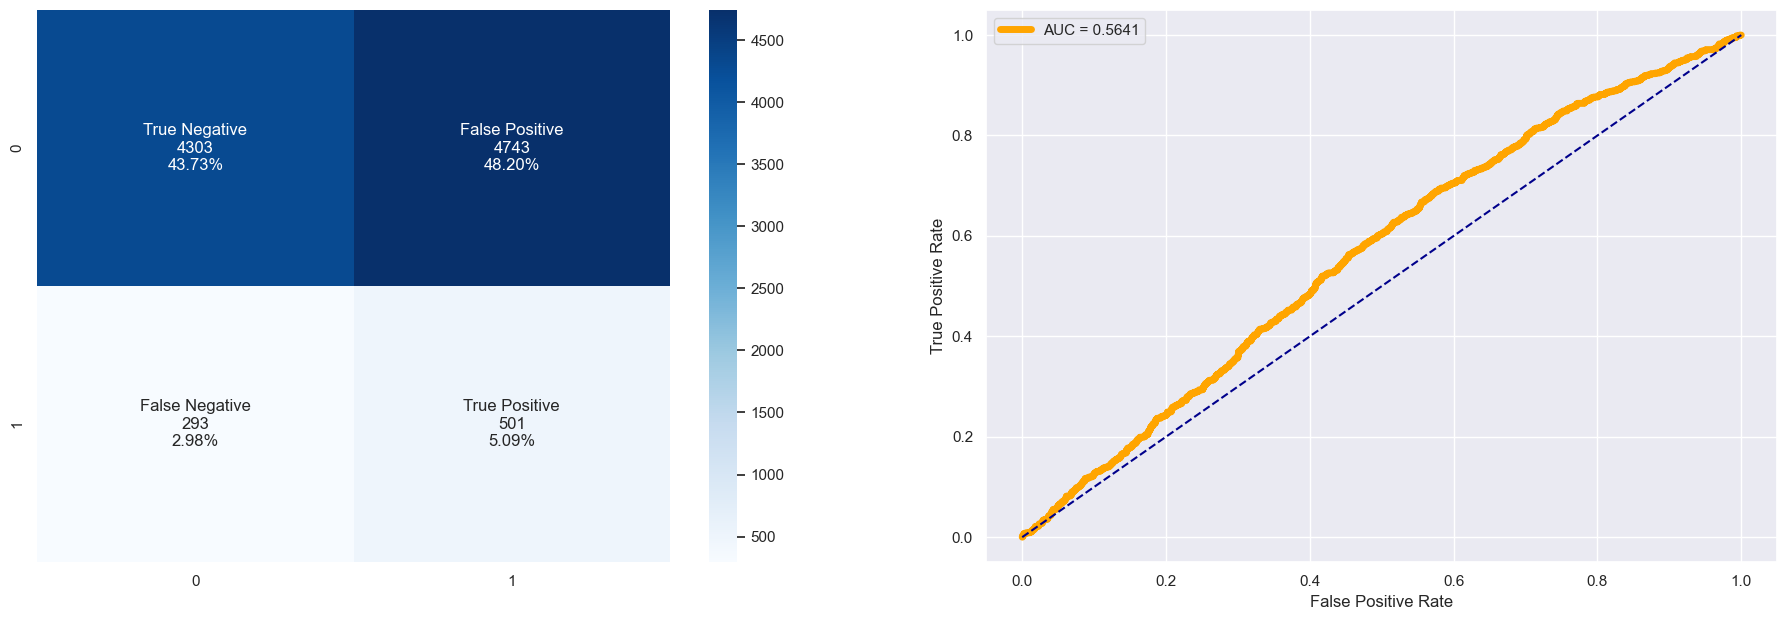

In [25]:
%time
# Create logistic regression model
lr = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1)
lr_name = 'LogisticRegression'

# Compute results 
lr_model, lr_results_cv, lr_results_test = train_model(lr_name, lr, cv=5, fast_train=0.2)

##### RandomForest

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 5.25 µs
{'fit_time': array([16.67317367, 16.90316892, 16.64704704, 16.76001596, 16.780936  ]), 'score_time': array([0.35027909, 0.16543913, 0.21111488, 0.22644114, 0.21349597]), 'test_accuracy': array([0.91552337, 0.91628557, 0.91628557, 0.91768293, 0.9171748 ]), 'test_precision': array([0.25806452, 0.2       , 0.22727273, 0.38181818, 0.30952381]), 'test_recall': array([0.02519685, 0.01259843, 0.01574803, 0.03307087, 0.02044025]), 'test_f1': array([0.04591105, 0.0237037 , 0.02945508, 0.06086957, 0.03834808]), 'test_roc_auc': array([0.67743703, 0.6892919 , 0.7154806 , 0.70785062, 0.70902986]), 'test_specificity': array([0.99364378, 0.99557828, 0.99530192, 0.99530192, 0.99599226]), 'test_fpr': array([-0.00635622, -0.00442172, -0.00469808, -0.00469808, -0.00400774]), 'test_business_score': array([0.01202577, 0.00343593, 0.00601288, 0.02333572, 0.0121498 ])}


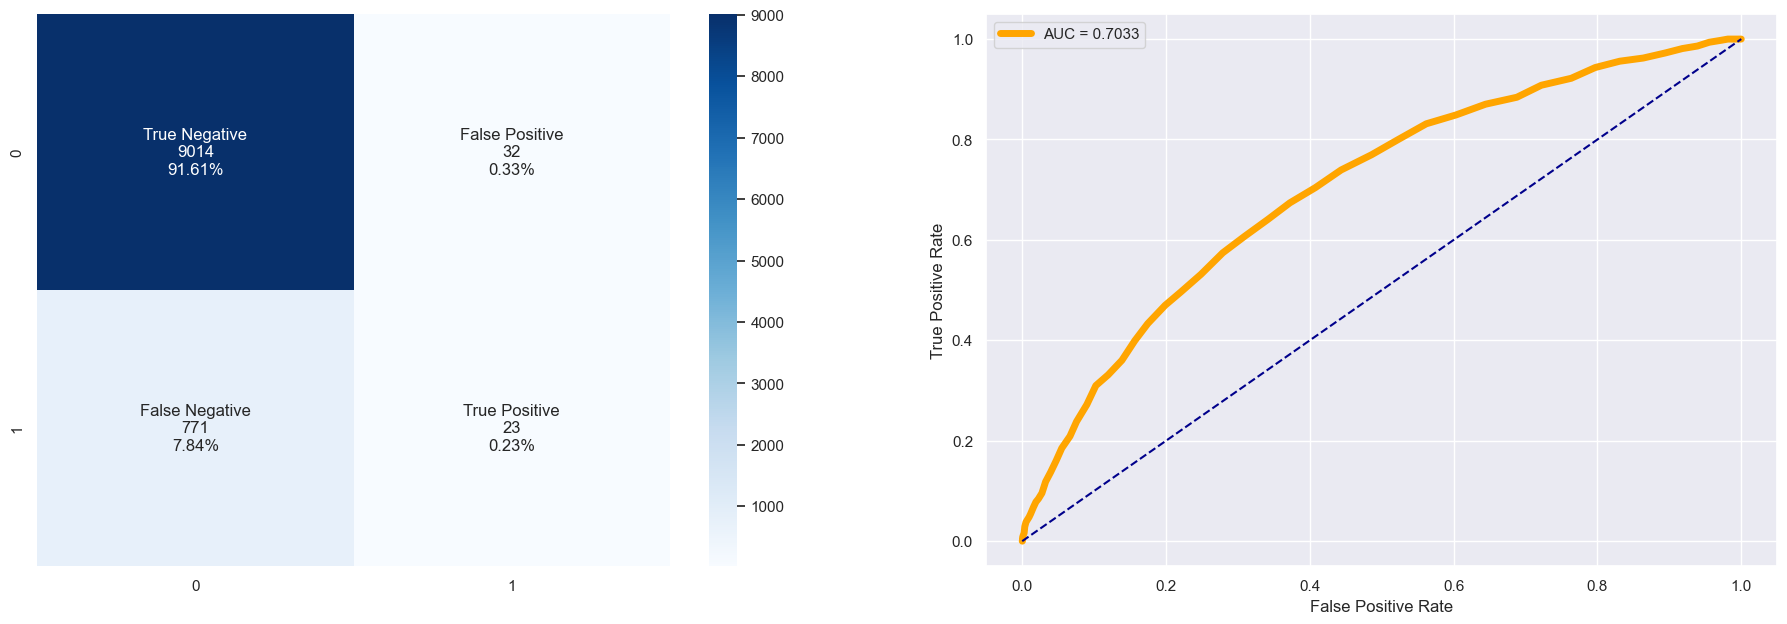

In [26]:
%time
# Create random forest classifier
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rf_name = 'RandomForest'

# Compute results 
rf_model, rf_results_cv, rf_results_test = train_model(rf_name, rf, cv=5, fast_train=0.2)

##### XGBoost

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:58:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:58:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:58:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:58:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parame

{'fit_time': array([8.7142427 , 8.76172996, 8.75662708, 8.71715212, 7.97389984]), 'score_time': array([0.16577935, 0.13566804, 0.14637399, 0.14625096, 0.09948993]), 'test_accuracy': array([0.89989837, 0.90205793, 0.90307419, 0.90027947, 0.90205793]), 'test_precision': array([0.27164179, 0.3045977 , 0.32122905, 0.28932584, 0.28706625]), 'test_recall': array([0.14330709, 0.16692913, 0.18110236, 0.16220472, 0.14308176]), 'test_f1': array([0.18762887, 0.21566633, 0.23162135, 0.20787084, 0.19097587]), 'test_roc_auc': array([0.70691492, 0.72162215, 0.75115782, 0.73170747, 0.70854215]), 'test_specificity': array([0.96628437, 0.96656073, 0.96642255, 0.96504076, 0.96876727]), 'test_fpr': array([-0.03371563, -0.03343927, -0.03357745, -0.03495924, -0.03123273]), 'test_business_score': array([0.07344309, 0.0976378 , 0.1115247 , 0.08976378, 0.07847341])}


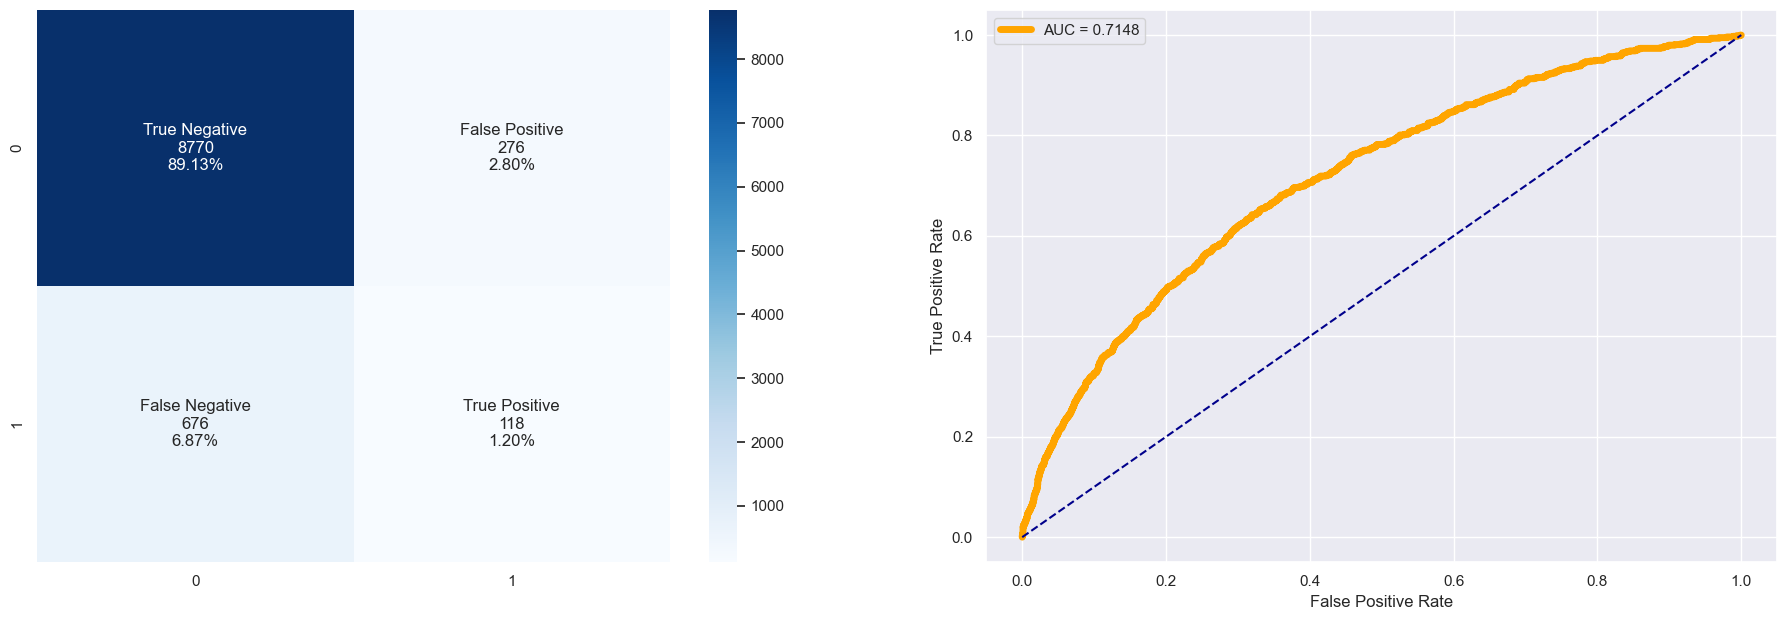

In [27]:
%time
# Create XGBoost classifier
xgbc = XGBClassifier(random_state=RANDOM_STATE, tree_method='auto', predictor='gpu_predictor')
xgbc_name = 'XGBoost'

# Compute results 
xgbc_model, xgbc_results_cv, xgbc_results_test = train_model(xgbc_name, xgbc, cv=5, fast_train=0.2)

##### LightGBM

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 2.86 µs
[LightGBM] [Info] Number of positive: 14474, number of negative: 14474
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75032
[LightGBM] [Info] Number of data points in the train set: 28948, number of used features: 389
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 14473, number of negative: 14473
[LightGBM] [Info] Number of positive: 14473, number of negative: 14473
[LightGBM] [Info] Number of positive: 14473, number of negative: 14473
[LightGBM] [Info] Number of positive: 14473, number of negative: 14473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74952
[Light

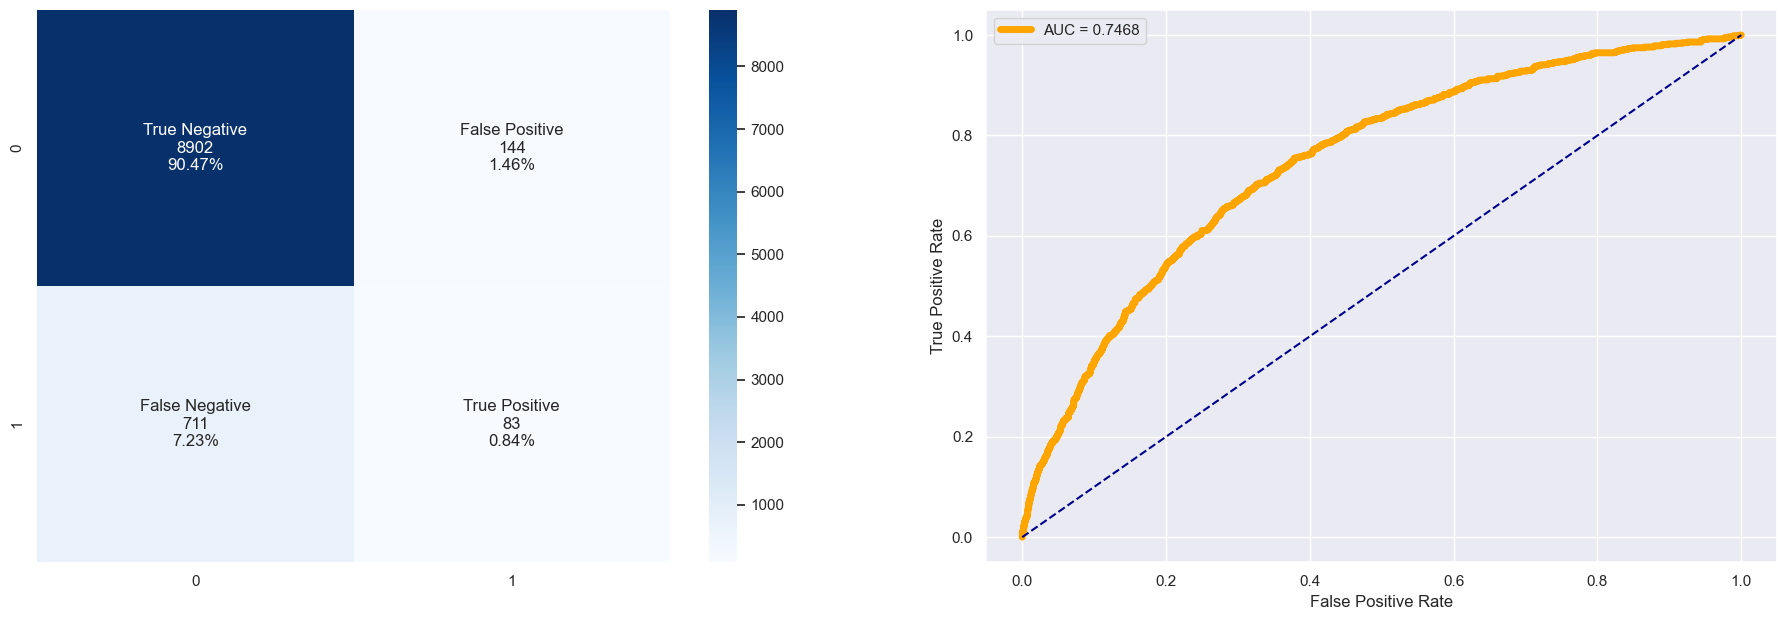

In [28]:
%time
# Create LightGBM classifier
lgbmc = LGBMClassifier(random_state=RANDOM_STATE, device='cpu', n_jobs=-1)
lgbmc_name = 'LightGBM'

# Compute results 
lgbmc_model, lgbmc_results_cv, lgbmc_results_test = train_model(lgbmc_name, lgbmc, cv=5, fast_train=0.2)

##### CatBoost

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs
Learning rate set to 0.043354
Learning rate set to 0.043354
0:	learn: 0.6421585	total: 102ms	remaining: 1m 42s
1:	learn: 0.6008877	total: 268ms	remaining: 2m 13s
Learning rate set to 0.043354
0:	learn: 0.6460903	total: 243ms	remaining: 4m 3s
2:	learn: 0.5734038	total: 423ms	remaining: 2m 20s
Learning rate set to 0.043354
Learning rate set to 0.043356
0:	learn: 0.6435516	total: 184ms	remaining: 3m 3s
1:	learn: 0.6051470	total: 433ms	remaining: 3m 36s
3:	learn: 0.5426131	total: 501ms	remaining: 2m 4s
2:	learn: 0.5679461	total: 533ms	remaining: 2m 57s
1:	learn: 0.6006104	total: 296ms	remaining: 2m 27s
4:	learn: 0.5129161	total: 604ms	remaining: 2m
0:	learn: 0.6457573	total: 182ms	remaining: 3m 1s
0:	learn: 0.6447034	total: 172ms	remaining: 2m 52s
3:	learn: 0.5352559	total: 645ms	remaining: 2m 40s
2:	learn: 0.5619858	total: 415ms	remaining: 2m 17s
5:	learn: 0.4874549	total: 707ms	remaining: 1m 57s
1:	learn: 0.6057437	to

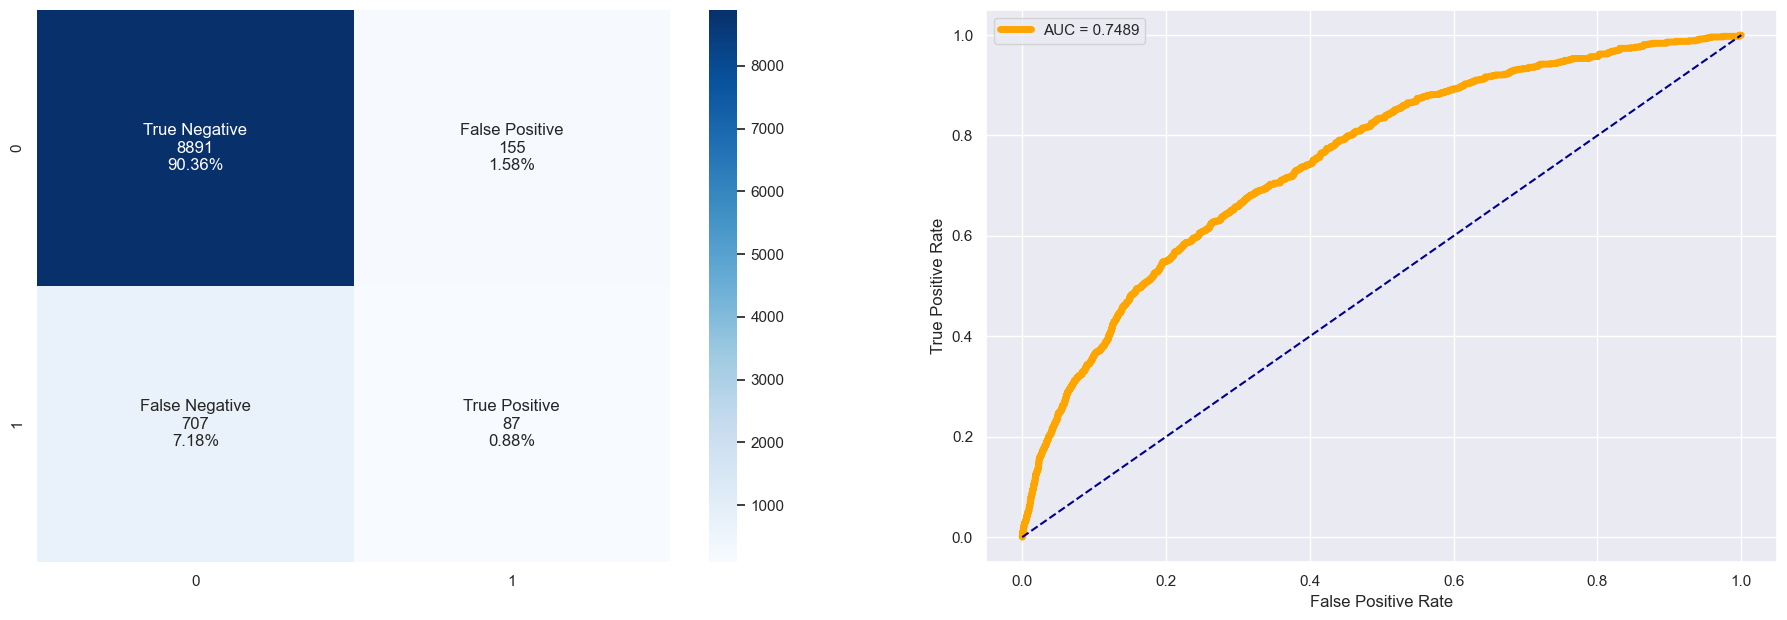

In [29]:
%time
# Create CatBoost classifier
cbc = CatBoostClassifier(random_state=RANDOM_STATE, task_type='CPU', logging_level='Verbose')
cbc_name = 'CatBoost'

# Compute results 
cbc_model, cbc_results_cv, cbc_results_test = train_model(cbc_name, cbc, cv=5, fast_train=0.2)

##### Comparison

In [30]:
results_cv = {
    'DummyClassifier': dc_results_cv,
    'LogisticRegression': lr_results_cv, 
    'RandomForest': rf_results_cv,
    'XGBoost': xgbc_results_cv,
    'LightGBM': lgbmc_results_cv,
    'CatBoost': cbc_results_cv
}

pd.DataFrame.from_dict(results_cv)

DummyClassifier  LogisticRegression  RandomForest   XGBoost  \
accuracy               0.491845            0.590803      0.916590  0.901474   
precision              0.077155            0.097531      0.275336  0.294772   
recall                 0.483318            0.481089      0.021411  0.159325   
f1                     0.133068            0.149307      0.039657  0.206753   
roc_auc                0.487956            0.568844      0.699818  0.723989   
specificity            0.492593            0.600430      0.995164  0.966615   
fpr                   -0.507407           -0.399570     -0.004836 -0.033385   
business_score        -0.567746           -0.346567      0.011392  0.090169   
fit_time               1.497305            3.266302     16.752868  8.584730   
execution_time         2.791130            4.299334     17.294095  9.306529   

                LightGBM   CatBoost  
accuracy        0.911052   0.912551  
precision       0.336173   0.367573  
recall          0.104532   0.116186  
f1              0.159425   0.176515  
roc_auc         0.751587   0.756921  
specificity     0.981843   0.982451  
fpr            -0.018157  -0.017549  
business_score  0.066919   0.079834  
fit_time        8.573965  88.413516  
execution_time  9.390185  89.240454

In [31]:
results_test = {
    'DummyClassifier': dc_results_test,
    'LogisticRegression': lr_results_test, 
    'RandomForest': rf_results_test,
    'XGBoost': xgbc_results_test,
    'LightGBM': lgbmc_results_test,
    'CatBoost': cbc_results_test
}

pd.DataFrame.from_dict(results_test)

DummyClassifier  LogisticRegression  RandomForest   XGBoost  \
fit_time               0.829854            3.004108      4.384726  3.390369   
accuracy               0.496138            0.488211      0.918394  0.903252   
precision              0.083100            0.095538      0.418182  0.299492   
recall                 0.522670            0.630982      0.028967  0.148615   
f1                     0.143400            0.165949      0.054181  0.198653   
roc_auc                0.508240            0.564053      0.703344  0.714777   
specificity            0.493809            0.475680      0.996463  0.969489   
fpr                    0.506191            0.524320      0.003537  0.030511   
business_score        -0.525876           -0.455118      0.021640  0.085413   

                LightGBM   CatBoost  
fit_time        2.948892  27.810122  
accuracy        0.913110   0.912398  
precision       0.365639   0.359504  
recall          0.104534   0.109572  
f1              0.162586   0.167954  
roc_auc         0.746812   0.748934  
specificity     0.984081   0.982865  
fpr             0.015919   0.017135  
business_score  0.071559   0.074078

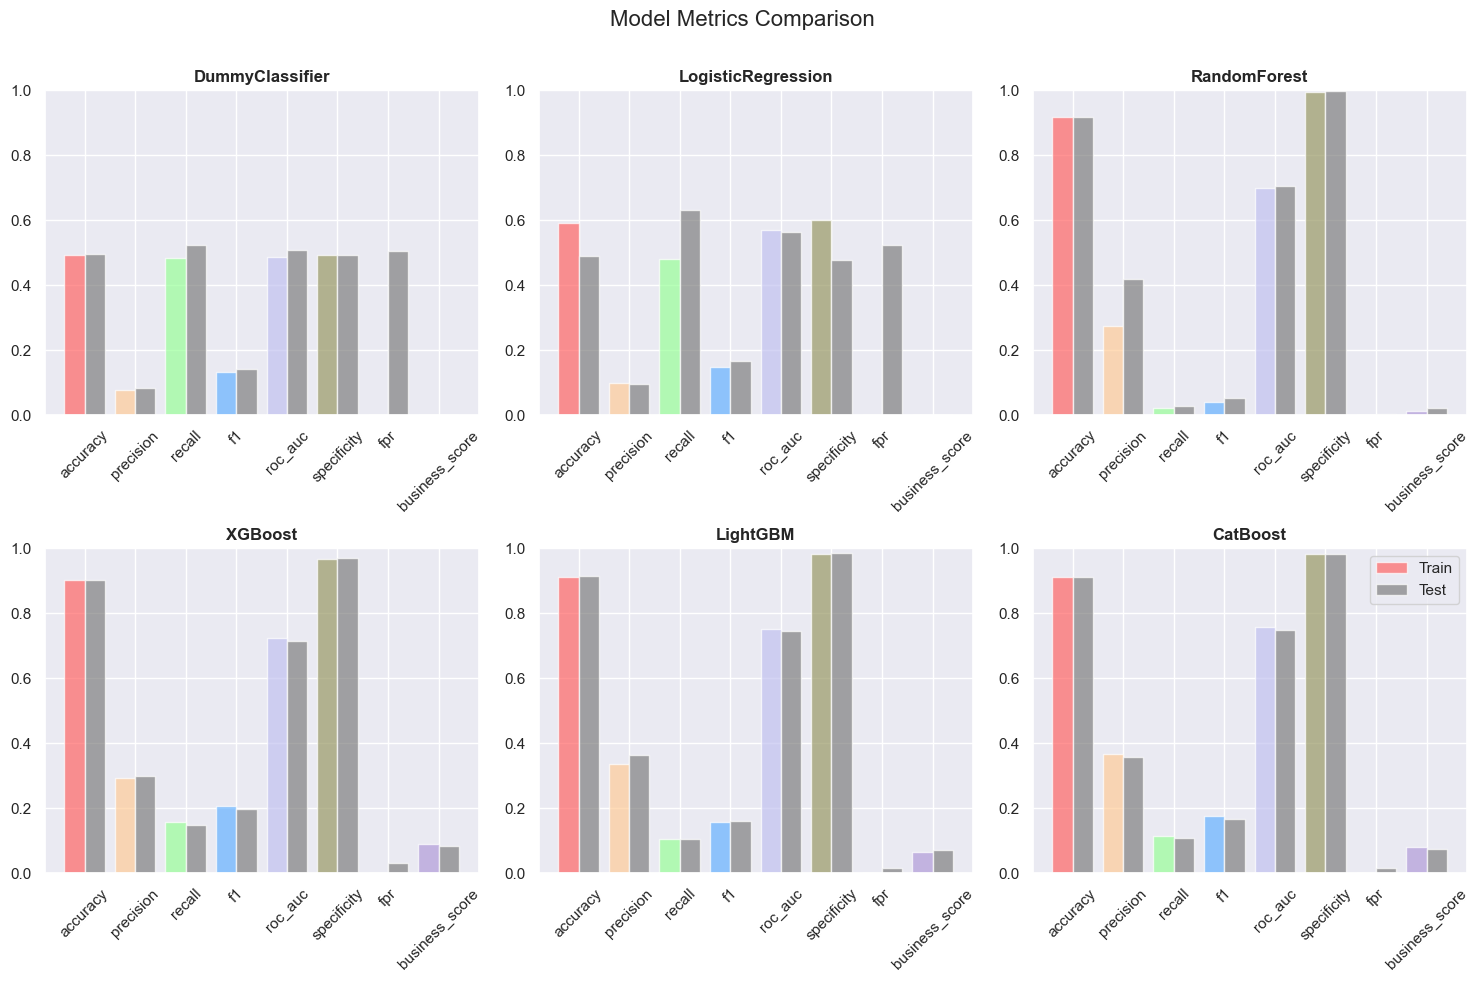

In [32]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'specificity', 'fpr', 'business_score']
plot_metrics(results_cv, results_test, metrics)

#### Hyperparameter optimization

For hyperparameter optimization, let's change few things for the sake of computation capacity: 
- Use 20% of total data

##### DummyClassifier (= baseline 0)

Since this one is the baseline 0, it does not need to be optimized.

##### Logistical regression (= baseline 1)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 4.29 µs
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.frame

[CV 2/5] END classifier__C=0.01, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.919) business_score: (test=0.000) f1: (test=0.000) fpr: (test=-0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.497) specificity: (test=1.000) total time=  14.0s
[CV 2/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.919) business_score: (test=0.000) f1: (test=0.000) fpr: (test=-0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.497) specificity: (test=1.000) total time=  14.1s
[CV 3/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.919) business_score: (test=0.000) f1: (test=0.000) fpr: (test=-0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.475) specificity: (test=1.000) total time=  14.2s
[CV 1/5] END classifier__C=0.01, classifier__max_iter=100, classifier__penal

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END classifier__C=0.01, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.919) business_score: (test=0.000) f1: (test=0.000) fpr: (test=-0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.475) specificity: (test=1.000) total time=  14.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.919) business_score: (test=0.000) f1: (test=0.000) fpr: (test=-0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.507) specificity: (test=1.000) total time=  14.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.919) business_score: (test=0.000) f1: (test=0.000) fpr: (test=-0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.477) specificity: (test=1.000) total time=  15.2s
[CV 4/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.919) business_score: (test=0.000) f1: (test=0.000) fpr: (test=-0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.496) specificity: (test=1.000) total time=  15.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and wil

[CV 5/5] END classifier__C=0.01, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.919) business_score: (test=0.000) f1: (test=0.000) fpr: (test=-0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.507) specificity: (test=1.000) total time=  15.2s
[CV 4/5] END classifier__C=0.01, classifier__max_iter=100, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.919) business_score: (test=0.000) f1: (test=0.000) fpr: (test=-0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.496) specificity: (test=1.000) total time=  15.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END classifier__C=10, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga; accuracy: (test=0.919) business_score: (test=0.000) f1: (test=0.000) fpr: (test=-0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.496) specificity: (test=1.000) total time=  14.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Pyth

[CV 5/5] END classifier__C=10, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga; accuracy: (test=0.919) business_score: (test=0.000) f1: (test=0.000) fpr: (test=-0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.507) specificity: (test=1.000) total time=  14.7s
[CV 2/5] END classifier__C=10, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga; accuracy: (test=0.919) business_score: (test=0.000) f1: (test=0.000) fpr: (test=-0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.497) specificity: (test=1.000) total time=  15.7s
[CV 3/5] END classifier__C=10, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=saga; accuracy: (test=0.919) business_score: (test=0.000) f1: (test=0.000) fpr: (test=-0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.475) specificity: (test=1.000) total time=  15.4s
[CV 1/5] END classifier__C=10, classifier__max_iter=100, classifier__penalty=l2, c

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.frame

[CV 1/5] END classifier__C=0.001, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs; accuracy: (test=0.491) business_score: (test=-0.418) f1: (test=0.174) fpr: (test=-0.524) precision: (test=0.100) recall: (test=0.663) roc_auc: (test=0.588) specificity: (test=0.476) total time=   4.1s
[CV 3/5] END classifier__C=0.001, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs; accuracy: (test=0.543) business_score: (test=-0.374) f1: (test=0.169) fpr: (test=-0.460) precision: (test=0.099) recall: (test=0.574) roc_auc: (test=0.561) specificity: (test=0.540) total time=   4.2s
[CV 2/5] END classifier__C=0.001, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs; accuracy: (test=0.463) business_score: (test=-0.488) f1: (test=0.165) fpr: (test=-0.554) precision: (test=0.094) recall: (test=0.655) roc_auc: (test=0.561) specificity: (test=0.446) total time=   4.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=5.68132e-23): result may not be accurate.
  warnings.warn(


[CV 5/5] END classifier__C=0.001, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs; accuracy: (test=0.652) business_score: (test=-0.284) f1: (test=0.152) fpr: (test=-0.325) precision: (test=0.095) recall: (test=0.386) roc_auc: (test=0.557) specificity: (test=0.675) total time=   2.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier__C=0.001, classifier__max_iter=100, classifier__penalty=l2, classifier__solver=lbfgs; accuracy: (test=0.488) business_score: (test=-0.452) f1: (test=0.166) fpr: (test=-0.525) precision: (test=0.096) recall: (test=0.630) roc_auc: (test=0.560) specificity: (test=0.475) total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=6.45364e-23): result may not be accurate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the fi

[CV 1/5] END classifier__C=0.01, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.552) business_score: (test=-0.337) f1: (test=0.177) fpr: (test=-0.452) precision: (test=0.104) recall: (test=0.594) roc_auc: (test=0.597) specificity: (test=0.548) total time=  11.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=5.98762e-23): result may not be accurate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_i

[CV 2/5] END classifier__C=0.01, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.543) business_score: (test=-0.395) f1: (test=0.163) fpr: (test=-0.457) precision: (test=0.095) recall: (test=0.547) roc_auc: (test=0.566) specificity: (test=0.543) total time=  12.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 3/5] END classifier__C=0.01, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.521) business_score: (test=-0.406) f1: (test=0.168) fpr: (test=-0.486) precision: (test=0.098) recall: (test=0.596) roc_auc: (test=0.572) specificity: (test=0.514) total time=  12.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=6.99575e-23): result may not be accurate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic

[CV 1/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=lbfgs; accuracy: (test=0.523) business_score: (test=-0.373) f1: (test=0.176) fpr: (test=-0.486) precision: (test=0.103) recall: (test=0.630) roc_auc: (test=0.593) specificity: (test=0.514) total time=   3.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 4/5] END classifier__C=0.01, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.527) business_score: (test=-0.391) f1: (test=0.170) fpr: (test=-0.479) precision: (test=0.099) recall: (test=0.597) roc_auc: (test=0.578) specificity: (test=0.521) total time=  12.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=lbfgs; accuracy: (test=0.534) business_score: (test=-0.406) f1: (test=0.163) fpr: (test=-0.468) precision: (test=0.095) recall: (test=0.560) roc_auc: (test=0.564) specificity: (test=0.532) total time=   3.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=lbfgs; accuracy: (test=0.543) business_score: (test=-0.374) f1: (test=0.169) fpr: (test=-0.460) precision: (test=0.099) recall: (test=0.574) roc_auc: (test=0.561) specificity: (test=0.540) total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
  

[CV 5/5] END classifier__C=0.01, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.532) business_score: (test=-0.343) f1: (test=0.182) fpr: (test=-0.478) precision: (test=0.106) recall: (test=0.643) roc_auc: (test=0.601) specificity: (test=0.522) total time=  12.1s
[CV 4/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=lbfgs; accuracy: (test=0.559) business_score: (test=-0.398) f1: (test=0.156) fpr: (test=-0.436) precision: (test=0.092) recall: (test=0.502) roc_auc: (test=0.556) specificity: (test=0.564) total time=   3.3s
[CV 5/5] END classifier__C=1, classifier__max_iter=100, classifier__penalty=none, classifier__solver=lbfgs; accuracy: (test=0.652) business_score: (test=-0.284) f1: (test=0.152) fpr: (test=-0.325) precision: (test=0.095) recall: (test=0.386) roc_auc: (test=0.557) specificity: (test=0.675) total time=   2.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.frame

[CV 2/5] END classifier__C=10, classifier__max_iter=500, classifier__penalty=none, classifier__solver=newton-cholesky; accuracy: (test=0.514) business_score: (test=-0.427) f1: (test=0.164) fpr: (test=-0.493) precision: (test=0.095) recall: (test=0.589) roc_auc: (test=0.563) specificity: (test=0.507) total time=  11.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 1/5] END classifier__C=10, classifier__max_iter=500, classifier__penalty=none, classifier__solver=newton-cholesky; accuracy: (test=0.547) business_score: (test=-0.322) f1: (test=0.183) fpr: (test=-0.459) precision: (test=0.107) recall: (test=0.625) roc_auc: (test=0.602) specificity: (test=0.541) total time=  12.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.frame

[CV 3/5] END classifier__C=10, classifier__max_iter=500, classifier__penalty=none, classifier__solver=newton-cholesky; accuracy: (test=0.498) business_score: (test=-0.446) f1: (test=0.164) fpr: (test=-0.511) precision: (test=0.095) recall: (test=0.608) roc_auc: (test=0.563) specificity: (test=0.489) total time=  11.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Matrix is singular.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear 

[CV 5/5] END classifier__C=10, classifier__max_iter=500, classifier__penalty=none, classifier__solver=newton-cholesky; accuracy: (test=0.490) business_score: (test=-0.415) f1: (test=0.175) fpr: (test=-0.526) precision: (test=0.101) recall: (test=0.669) roc_auc: (test=0.590) specificity: (test=0.474) total time=   9.8s
[CV 4/5] END classifier__C=10, classifier__max_iter=500, classifier__penalty=none, classifier__solver=newton-cholesky; accuracy: (test=0.535) business_score: (test=-0.378) f1: (test=0.171) fpr: (test=-0.470) precision: (test=0.100) recall: (test=0.591) roc_auc: (test=0.583) specificity: (test=0.530) total time=  10.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.frame

[CV 1/5] END classifier__C=0.001, classifier__max_iter=500, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.919) business_score: (test=0.000) f1: (test=0.000) fpr: (test=-0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.492) specificity: (test=1.000) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

[CV 2/5] END classifier__C=0.001, classifier__max_iter=500, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.919) business_score: (test=0.000) f1: (test=0.000) fpr: (test=-0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.512) specificity: (test=1.000) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END classifier__C=0.001, classifier__max_iter=500, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.919) business_score: (test=0.000) f1: (test=0.000) fpr: (test=-0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.496) specificity: (test=1.000) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra

[CV 1/5] END classifier__C=10, classifier__max_iter=1000, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.919) business_score: (test=0.000) f1: (test=0.000) fpr: (test=-0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.501) specificity: (test=1.000) total time= 2.5min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.12752e-24): result may not be accurate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_i

[CV 1/5] END classifier__C=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.503) business_score: (test=-0.391) f1: (test=0.178) fpr: (test=-0.511) precision: (test=0.103) recall: (test=0.661) roc_auc: (test=0.600) specificity: (test=0.489) total time=  10.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=9.93224e-25): result may not be accurate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_i

[CV 2/5] END classifier__C=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.515) business_score: (test=-0.420) f1: (test=0.166) fpr: (test=-0.492) precision: (test=0.096) recall: (test=0.594) roc_auc: (test=0.564) specificity: (test=0.508) total time=  11.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.04883e-24): result may not be accurate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defi

[CV 4/5] END classifier__C=10, classifier__max_iter=1000, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.919) business_score: (test=0.000) f1: (test=0.000) fpr: (test=-0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.505) specificity: (test=1.000) total time= 2.5min
[CV 2/5] END classifier__C=10, classifier__max_iter=1000, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.919) business_score: (test=0.000) f1: (test=0.000) fpr: (test=-0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.520) specificity: (test=1.000) total time= 2.5min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 3/5] END classifier__C=10, classifier__max_iter=1000, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.919) business_score: (test=0.000) f1: (test=0.000) fpr: (test=-0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.505) specificity: (test=1.000) total time= 2.5min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 3/5] END classifier__C=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.508) business_score: (test=-0.418) f1: (test=0.169) fpr: (test=-0.502) precision: (test=0.098) recall: (test=0.616) roc_auc: (test=0.567) specificity: (test=0.498) total time=  11.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END classifier__C=10, classifier__max_iter=1000, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.919) business_score: (test=0.000) f1: (test=0.000) fpr: (test=-0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.530) specificity: (test=1.000) total time= 2.5min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:498: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration #1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.2186e-24): result may not be accurate.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_it

[CV 4/5] END classifier__C=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.549) business_score: (test=-0.370) f1: (test=0.168) fpr: (test=-0.452) precision: (test=0.099) recall: (test=0.561) roc_auc: (test=0.577) specificity: (test=0.548) total time=   9.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_glm/_newton_solver.py:195: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


[CV 5/5] END classifier__C=1, classifier__max_iter=500, classifier__penalty=l2, classifier__solver=newton-cholesky; accuracy: (test=0.559) business_score: (test=-0.310) f1: (test=0.183) fpr: (test=-0.446) precision: (test=0.107) recall: (test=0.608) roc_auc: (test=0.602) specificity: (test=0.554) total time=   7.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 4/5] END classifier__C=0.001, classifier__max_iter=500, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.919) business_score: (test=0.000) f1: (test=0.000) fpr: (test=-0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.502) specificity: (test=1.000) total time=  57.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV 5/5] END classifier__C=0.001, classifier__max_iter=500, classifier__penalty=none, classifier__solver=saga; accuracy: (test=0.919) business_score: (test=0.000) f1: (test=0.000) fpr: (test=-0.000) precision: (test=0.000) recall: (test=0.000) roc_auc: (test=0.524) specificity: (test=1.000) total time=  52.1s


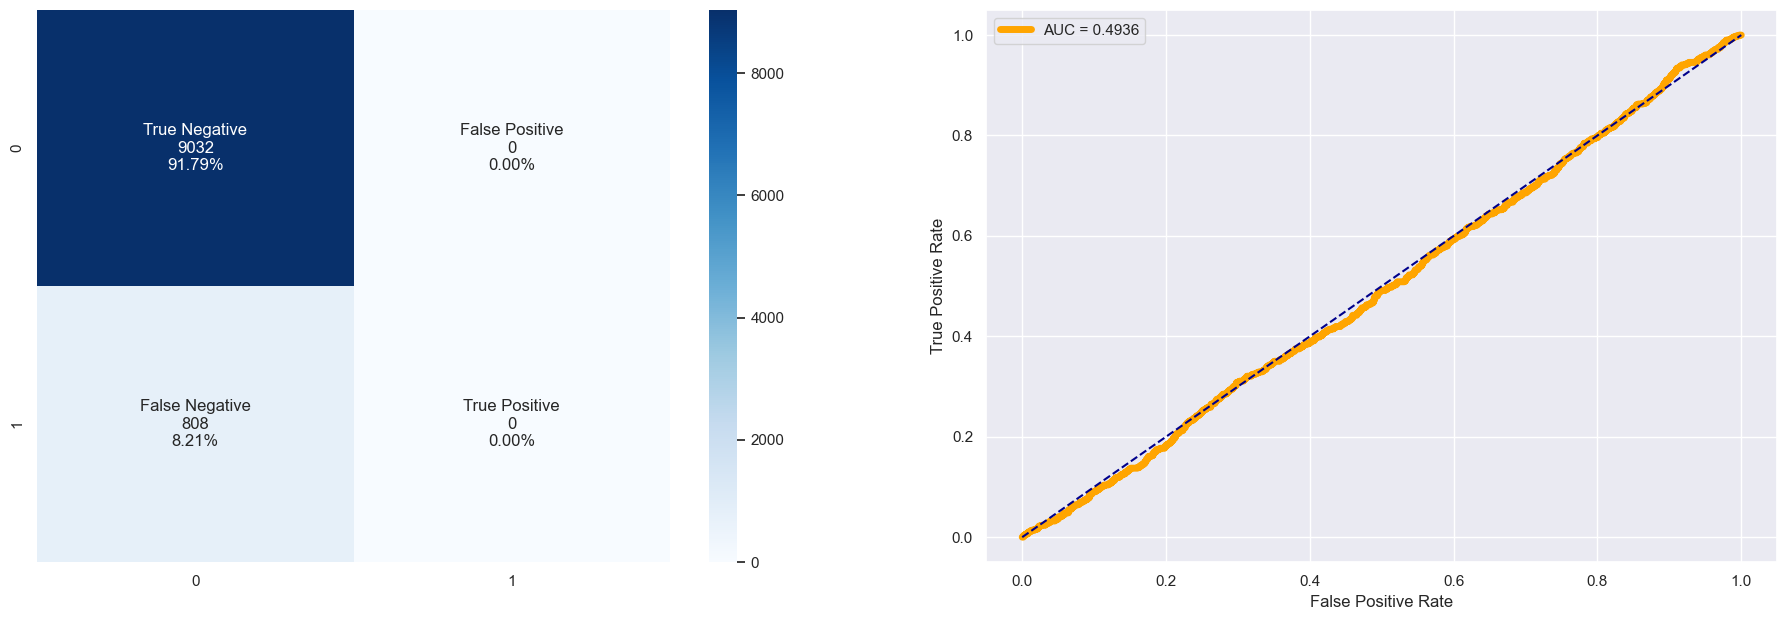

In [33]:
%time
# Create logistic regression model
lrt = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1)
lrt_name = 'LogisticRegression_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__C': [0.001, 0.01, 1, 10, 100],  # Regularization strength
    'classifier__penalty': ['l2', 'none'],  # Regularization penalty --> only use l2 due to one-hot encode
    'classifier__solver': ['lbfgs', 'saga', 'newton-cholesky'],  # Solver options
    'classifier__max_iter': [100, 500, 1000],  # Maximum iterations
}

# Compute results and get fine-tuned model
lrt_model, lrt_results_cv, lrt_results_test = search_hyperparameters(lrt_name, lrt, param_grid=param_grid, cv=5, fast_train=0.2)

##### RandomForest

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 4.05 µs
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 4/5] END classifier__max_depth=10, classifier__max_features=auto, classifier__min_samples_split=2, classifier__n_estimators=100; accuracy: (test=nan) business_score: (test=nan) f1: (test=nan) fpr: (test=nan) precision: (test=nan) recall: (test=nan) roc_auc: (test=nan) specificity: (test=nan) total time=   1.5s
[CV 1/5] END classifier__max_depth=10, classifier__max_features=auto, classifier__min_samples_split=2, classifier__n_estimators=100; accuracy: (test=nan) business_score: (test=nan) f1: (test=nan) fpr: (test=nan) precision: (test=nan) recall: (test=nan) roc_auc: (test=nan) specificity: (test=nan) total time=   1.7s
[CV 3/5] END classifier__max_depth=10, classifier__max_features=auto, classifier__min_samples_split=2, classifier__n_estimators=100; accuracy: (test=nan) business_score: (test=nan) f1: (test=nan) fpr: (test=nan) precision: (test=nan) recal

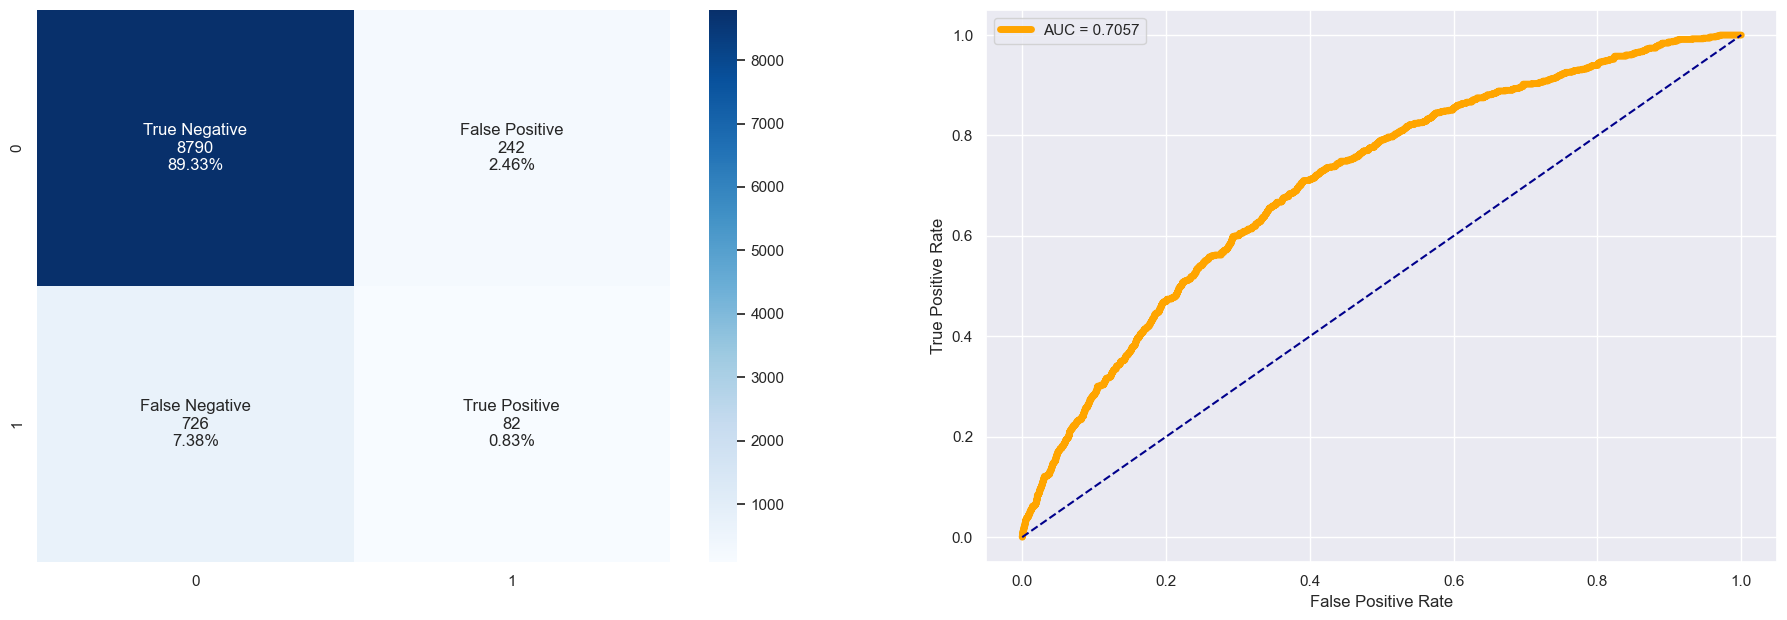

In [34]:
%time
# Create random forest classifier
rft = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rft_name = 'RandomForest_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__max_features': ['auto', 'sqrt'],
}

# Compute results and get fine-tuned model
rft_model, rft_results_cv, rft_results_test = search_hyperparameters(rft_name, rft, param_grid=param_grid, cv=5, fast_train=0.2)

##### XGBoost

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs
Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:08:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:08:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:08:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:08:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parame

[CV 2/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.879) business_score: (test=0.021) f1: (test=0.153) fpr: (test=-0.055) precision: (test=0.177) recall: (test=0.135) roc_auc: (test=0.668) specificity: (test=0.945) total time=   6.9s
[CV 1/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.896) business_score: (test=0.038) f1: (test=0.146) fpr: (test=-0.035) precision: (test=0.217) recall: (test=0.110) roc_auc: (test=0.672) specificity: (test=0.965) total time=   6.9s
[CV 3/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.893) business_score: (test=0.034) f1: (test=0.146) fpr: (test=-0.038) precision: (test=0.207) recall: (test=0.113) roc_auc: (test=0.661) specificity: (test=0.962) total time=   7.1s
[CV 2/5] END classifie

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:08:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:08:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:08:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:08:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parame

[CV 5/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.887) business_score: (test=0.033) f1: (test=0.155) fpr: (test=-0.045) precision: (test=0.198) recall: (test=0.127) roc_auc: (test=0.648) specificity: (test=0.955) total time=   6.1s
[CV 4/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.882) business_score: (test=0.011) f1: (test=0.136) fpr: (test=-0.050) precision: (test=0.167) recall: (test=0.114) roc_auc: (test=0.662) specificity: (test=0.950) total time=   6.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:08:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:08:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.914) business_score: (test=0.052) f1: (test=0.126) fpr: (test=-0.012) precision: (test=0.358) recall: (test=0.077) roc_auc: (test=0.748) specificity: (test=0.988) total time=   8.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:08:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.917) business_score: (test=0.083) f1: (test=0.174) fpr: (test=-0.012) precision: (test=0.439) recall: (test=0.108) roc_auc: (test=0.753) specificity: (test=0.988) total time=   8.0s
[CV 3/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.916) business_score: (test=0.051) f1: (test=0.120) fpr: (test=-0.009) precision: (test=0.398) recall: (test=0.071) roc_auc: (test=0.744) specificity: (test=0.991) total time=   7.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:08:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:08:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 4/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.913) business_score: (test=0.039) f1: (test=0.107) fpr: (test=-0.012) precision: (test=0.315) recall: (test=0.064) roc_auc: (test=0.719) specificity: (test=0.988) total time=   8.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:08:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 5/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.916) business_score: (test=0.065) f1: (test=0.145) fpr: (test=-0.011) precision: (test=0.412) recall: (test=0.088) roc_auc: (test=0.730) specificity: (test=0.989) total time=   7.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:08:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__learning_rate=0.01, classifier__max_depth=9, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.915) business_score: (test=0.048) f1: (test=0.118) fpr: (test=-0.011) precision: (test=0.363) recall: (test=0.071) roc_auc: (test=0.717) specificity: (test=0.989) total time=  18.4s
[CV 1/5] END classifier__learning_rate=0.01, classifier__max_depth=9, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.915) business_score: (test=0.040) f1: (test=0.102) fpr: (test=-0.009) precision: (test=0.362) recall: (test=0.060) roc_auc: (test=0.729) specificity: (test=0.991) total time=  33.3s
[CV 2/5] END classifier__learning_rate=0.01, classifier__max_depth=9, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.915) business_score: (test=0.045) f1: (test=0.113) fpr: (test=-0.011) precision: (test=0.358) recall: (test=0.067) roc_auc: (test=0.733) specificity: (test=0.989) total time=  33.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:08:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 3/5] END classifier__learning_rate=0.01, classifier__max_depth=9, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.915) business_score: (test=0.024) f1: (test=0.072) fpr: (test=-0.008) precision: (test=0.302) recall: (test=0.041) roc_auc: (test=0.725) specificity: (test=0.992) total time=  34.0s
[CV 5/5] END classifier__learning_rate=0.01, classifier__max_depth=9, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.915) business_score: (test=0.040) f1: (test=0.102) fpr: (test=-0.010) precision: (test=0.352) recall: (test=0.060) roc_auc: (test=0.713) specificity: (test=0.990) total time=  33.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:08:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__learning_rate=0.01, classifier__max_depth=9, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.912) business_score: (test=0.042) f1: (test=0.115) fpr: (test=-0.014) precision: (test=0.312) recall: (test=0.071) roc_auc: (test=0.724) specificity: (test=0.986) total time=  18.0s
[CV 4/5] END classifier__learning_rate=0.01, classifier__max_depth=9, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.913) business_score: (test=0.021) f1: (test=0.073) fpr: (test=-0.010) precision: (test=0.265) recall: (test=0.042) roc_auc: (test=0.700) specificity: (test=0.990) total time=  35.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:09:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:09:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:09:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:09:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parame

[CV 3/5] END classifier__learning_rate=0.01, classifier__max_depth=9, classifier__n_estimators=50, classifier__subsample=0.8; accuracy: (test=0.915) business_score: (test=0.025) f1: (test=0.074) fpr: (test=-0.008) precision: (test=0.310) recall: (test=0.042) roc_auc: (test=0.720) specificity: (test=0.992) total time=  18.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:09:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.9; accuracy: (test=0.916) business_score: (test=0.044) f1: (test=0.108) fpr: (test=-0.009) precision: (test=0.385) recall: (test=0.063) roc_auc: (test=0.728) specificity: (test=0.991) total time=   5.9s
[CV 2/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.9; accuracy: (test=0.915) business_score: (test=0.046) f1: (test=0.114) fpr: (test=-0.010) precision: (test=0.368) recall: (test=0.067) roc_auc: (test=0.728) specificity: (test=0.990) total time=   5.9s
[CV 3/5] END classifier__learning_rate=0.1, classifier__max_depth=3, classifier__n_estimators=50, classifier__subsample=0.9; accuracy: (test=0.915) business_score: (test=0.025) f1: (test=0.074) fpr: (test=-0.008) precision: (test=0.310) recall: (test=0.042) roc_auc: (test=0.722) specificity: (test=0.992) total time=   6.2s
[CV 4/5] END classifier__

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:09:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:09:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:09:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:09:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parame

[CV 1/5] END classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=50, classifier__subsample=0.9; accuracy: (test=0.910) business_score: (test=0.043) f1: (test=0.122) fpr: (test=-0.016) precision: (test=0.292) recall: (test=0.077) roc_auc: (test=0.703) specificity: (test=0.984) total time=   9.5s
[CV 2/5] END classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=50, classifier__subsample=0.9; accuracy: (test=0.908) business_score: (test=0.025) f1: (test=0.097) fpr: (test=-0.017) precision: (test=0.236) recall: (test=0.061) roc_auc: (test=0.704) specificity: (test=0.983) total time=   9.6s
[CV 3/5] END classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=50, classifier__subsample=0.9; accuracy: (test=0.907) business_score: (test=0.024) f1: (test=0.098) fpr: (test=-0.019) precision: (test=0.229) recall: (test=0.063) roc_auc: (test=0.690) specificity: (test=0.981) total time=   9.7s
[CV 5/5] END classifie

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:09:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:09:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:09:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:09:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parame

[CV 3/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.903) business_score: (test=0.050) f1: (test=0.149) fpr: (test=-0.027) precision: (test=0.258) recall: (test=0.105) roc_auc: (test=0.678) specificity: (test=0.973) total time=   8.4s
[CV 1/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.902) business_score: (test=0.045) f1: (test=0.144) fpr: (test=-0.028) precision: (test=0.246) recall: (test=0.102) roc_auc: (test=0.686) specificity: (test=0.972) total time=   8.6s
[CV 2/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.888) business_score: (test=0.035) f1: (test=0.156) fpr: (test=-0.044) precision: (test=0.201) recall: (test=0.127) roc_auc: (test=0.688) specificity: (test=0.956) total time=   8.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:09:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:09:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:09:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 1/5] END classifier__learning_rate=0.3, classifier__max_depth=6, classifier__n_estimators=200, classifier__subsample=0.9; accuracy: (test=0.900) business_score: (test=0.083) f1: (test=0.199) fpr: (test=-0.034) precision: (test=0.282) recall: (test=0.154) roc_auc: (test=0.713) specificity: (test=0.966) total time=  23.1s
[CV 4/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.896) business_score: (test=0.016) f1: (test=0.114) fpr: (test=-0.033) precision: (test=0.183) recall: (test=0.083) roc_auc: (test=0.674) specificity: (test=0.967) total time=   8.5s
[CV 5/5] END classifier__learning_rate=0.01, classifier__max_depth=3, classifier__n_estimators=100, classifier__subsample=0.9; accuracy: (test=0.895) business_score: (test=0.035) f1: (test=0.143) fpr: (test=-0.036) precision: (test=0.212) recall: (test=0.108) roc_auc: (test=0.670) specificity: (test=0.964) total time=   8.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:09:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:09:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:09:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__learning_rate=0.3, classifier__max_depth=6, classifier__n_estimators=200, classifier__subsample=0.9; accuracy: (test=0.904) business_score: (test=0.115) f1: (test=0.235) fpr: (test=-0.032) precision: (test=0.330) recall: (test=0.182) roc_auc: (test=0.724) specificity: (test=0.968) total time=  22.6s
[CV 3/5] END classifier__learning_rate=0.3, classifier__max_depth=6, classifier__n_estimators=200, classifier__subsample=0.9; accuracy: (test=0.902) business_score: (test=0.077) f1: (test=0.188) fpr: (test=-0.030) precision: (test=0.288) recall: (test=0.139) roc_auc: (test=0.717) specificity: (test=0.970) total time=  22.9s
[CV 5/5] END classifier__learning_rate=0.3, classifier__max_depth=6, classifier__n_estimators=200, classifier__subsample=0.9; accuracy: (test=0.904) business_score: (test=0.111) f1: (test=0.229) fpr: (test=-0.031) precision: (test=0.330) recall: (test=0.176) roc_auc: (test=0.720) specificity: (test=0.969) total time=  22.2s
[CV 4/5] END classifie

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [15:09:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[CV 2/5] END classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=100, classifier__subsample=0.8; accuracy: (test=0.910) business_score: (test=0.037) f1: (test=0.111) fpr: (test=-0.016) precision: (test=0.280) recall: (test=0.069) roc_auc: (test=0.717) specificity: (test=0.984) total time=  12.6s
[CV 3/5] END classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=100, classifier__subsample=0.8; accuracy: (test=0.913) business_score: (test=0.028) f1: (test=0.086) fpr: (test=-0.011) precision: (test=0.296) recall: (test=0.050) roc_auc: (test=0.708) specificity: (test=0.989) total time=  11.3s
[CV 4/5] END classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=100, classifier__subsample=0.8; accuracy: (test=0.911) business_score: (test=0.019) f1: (test=0.076) fpr: (test=-0.013) precision: (test=0.238) recall: (test=0.045) roc_auc: (test=0.695) specificity: (test=0.987) total time=  11.7s
[CV 5/5] END classi

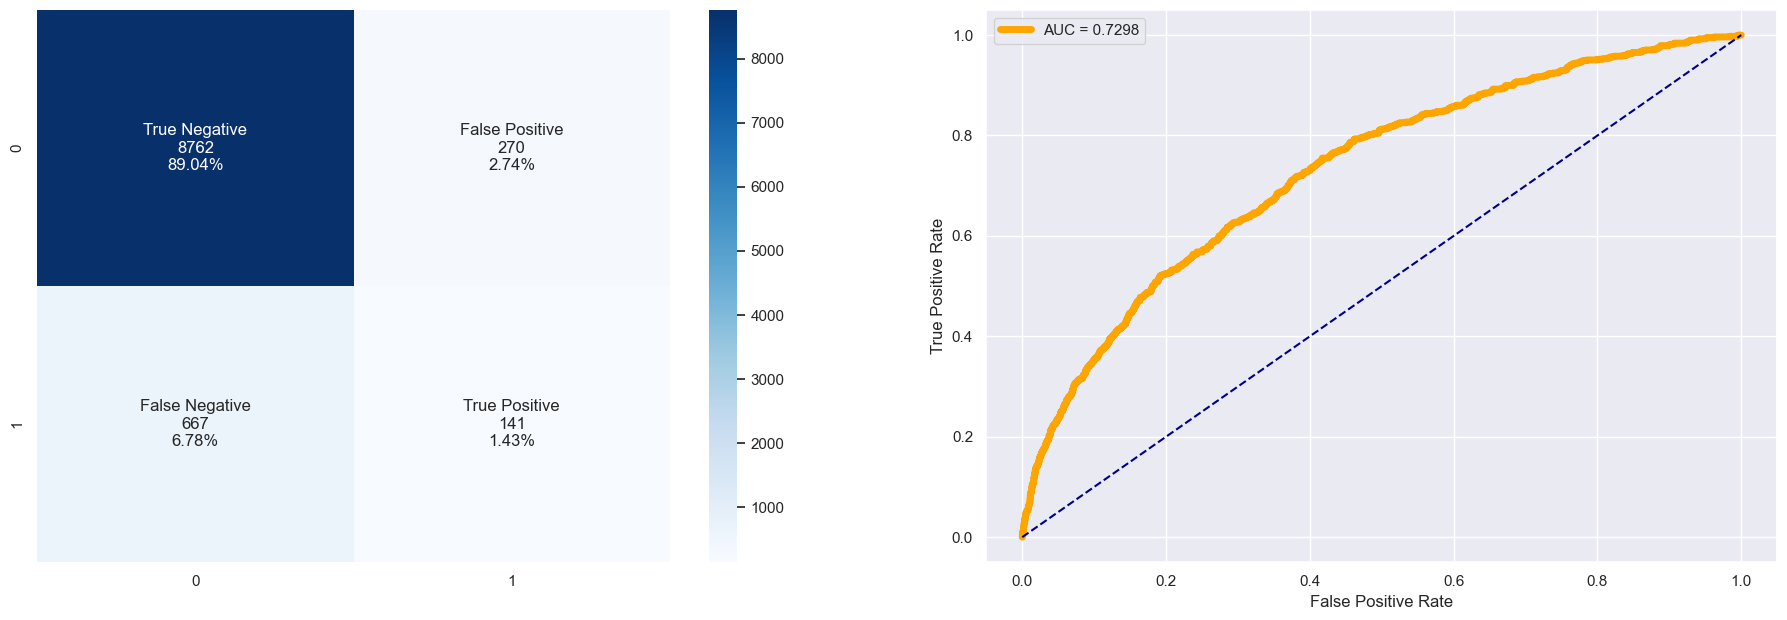

In [35]:
%time
# Create XGBoost classifier
xgbct = XGBClassifier(random_state=RANDOM_STATE, tree_method='auto', predictor='gpu_predictor')
xgbct_name = 'XGBoost_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.8, 0.9, 1.0]
}

# Compute results and get fine-tuned model
xgbct_model, xgbct_results_cv, xgbct_results_test = search_hyperparameters(xgbct_name, xgbct, param_grid=param_grid, cv=5, fast_train=0.2)

##### LightGBM

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 5.01 µs
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.338818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98753
[LightGBM] [Info] Number of data points in the train set: 28936, number of used features: 492
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.524571 seconds.
You can set `force_col_wise=true` 

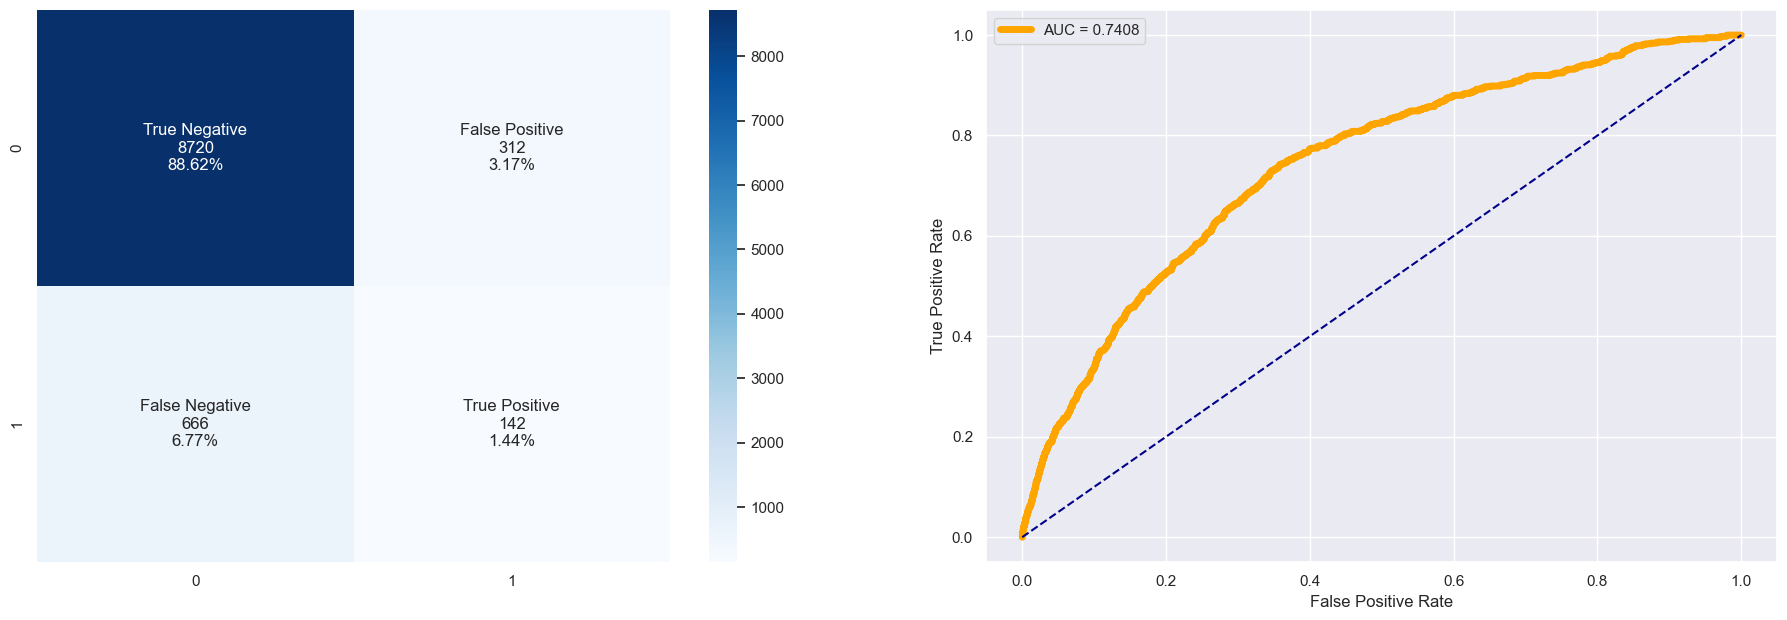

In [131]:
%time
# Create LightGBM classifier
lgbmct = LGBMClassifier(random_state=RANDOM_STATE, device='cpu', n_jobs=-1)
lgbmct_name = 'LightGBM_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3 , 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.8, 0.9, 1.0]
}

# Compute results and get fine-tuned model
lgbmct_model, lgbmct_results_cv, lgbmct_results_test = search_hyperparameters(lgbmct_name, lgbmct, param_grid=param_grid, cv=5, fast_train=0.2)

##### CatBoost

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 0.5874466	total: 460ms	remaining: 22.6s
0:	learn: 0.6806892	total: 352ms	remaining: 17.3s
0:	learn: 0.5857402	total: 576ms	remaining: 28.2s
0:	learn: 0.5803589	total: 612ms	remaining: 30s
0:	learn: 0.6813492	total: 425ms	remaining: 20.8s
1:	learn: 0.6690258	total: 720ms	remaining: 17.3s
1:	learn: 0.5086952	total: 908ms	remaining: 21.8s
0:	learn: 0.5942481	total: 441ms	remaining: 21.6s
1:	learn: 0.5079409	total: 988ms	remaining: 23.7s
1:	learn: 0.6699053	total: 724ms	remaining: 17.4s
2:	learn: 0.6575098	total: 989ms	remaining: 15.5s
0:	learn: 0.6824834	total: 392ms	remaining: 19.2s
1:	learn: 0.5048590	total: 1.1s	remaining: 26.5s
2:	learn: 0.4485437	total: 1.33s	remaining: 20.9s
1:	learn: 0.5293835	total: 853ms	remaining: 20.5s
2:	learn: 0.6609557	total: 959ms	remaining: 15s
1:	learn: 0.6695898	total: 685ms	remaining: 16.4s
2:	learn: 0.4594011	total: 

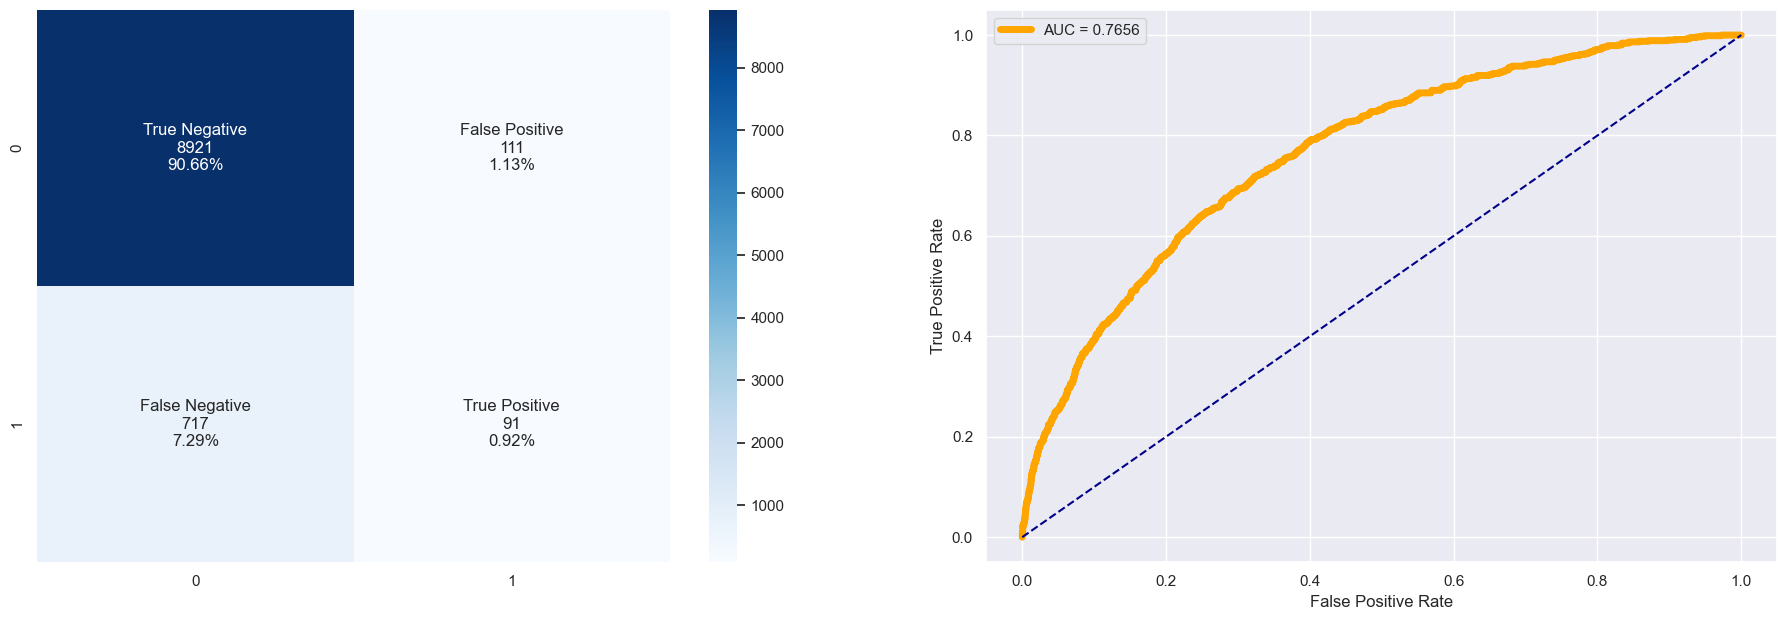

In [37]:
%time
# Create CatBoost classifier
cbct = CatBoostClassifier(random_state=RANDOM_STATE, task_type='CPU', logging_level='Verbose')
cbct_name = 'CatBoost_fine_tuned'

# Set hyperparameter grid
param_grid = {
    'classifier__iterations': [50, 100, 200],
    'classifier__depth': [6, 8, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.8, 0.9, 1.0],  
}

# Compute results and get fine-tuned model
cbct_model, cbct_results_cv, cbct_results_test = search_hyperparameters(cbct_name, cbct, param_grid=param_grid, cv=5, fast_train=0.2)

##### Comparison

In [38]:
results_cv_tuned = {
    'DummyClassifier': dc_results_cv,
    'LogisticRegression': lrt_results_cv, 
    'RandomForest': rft_results_cv,
    'XGBoost': xgbct_results_cv,
    'LightGBM': lgbmct_results_cv,
    'CatBoost': cbct_results_cv
}

pd.DataFrame.from_dict(results_cv_tuned)

DummyClassifier  LogisticRegression  RandomForest    XGBoost  \
accuracy               0.491845            0.918953      0.902820   0.902617   
precision              0.077155            0.000000      0.248404   0.305945   
recall                 0.483318            0.000000      0.097492   0.159561   
f1                     0.133068            0.000000      0.139546   0.209614   
roc_auc                0.487956            0.490593      0.703041   0.715857   
specificity            0.492593            1.000000      0.973846   0.968150   
fpr                   -0.507407            0.000000     -0.026154  -0.031850   
business_score        -0.567746            0.000000      0.043574   0.093901   
fit_time               1.497305                 NaN           NaN        NaN   
execution_time         2.791130                 NaN           NaN        NaN   
search_time                 NaN          218.760938    108.981373  95.258103   

                 LightGBM    CatBoost  
accuracy         0.900711    0.913161  
precision        0.289079    0.371701  
recall           0.155172    0.105329  
f1               0.201564    0.163883  
roc_auc          0.717876    0.750669  
specificity      0.966464    0.984407  
fpr             -0.033536   -0.015593  
business_score   0.086036    0.073183  
fit_time              NaN         NaN  
execution_time        NaN         NaN  
search_time     60.707795  247.422246

In [39]:
results_test_tuned = {
    'DummyClassifier': dc_results_test,
    'LogisticRegression': lrt_results_test, 
    'RandomForest': rft_results_test,
    'XGBoost': xgbct_results_test,
    'LightGBM': lgbmct_results_test,
    'CatBoost': cbct_results_test
}

pd.DataFrame.from_dict(results_test_tuned)

DummyClassifier  LogisticRegression  RandomForest   XGBoost  \
fit_time               0.829854                 NaN           NaN       NaN   
accuracy               0.496138            0.917886      0.901626  0.904776   
precision              0.083100            0.000000      0.253086  0.343066   
recall                 0.522670            0.000000      0.101485  0.174505   
f1                     0.143400            0.000000      0.144876  0.231337   
roc_auc                0.508240            0.493553      0.705742  0.729846   
specificity            0.493809            1.000000      0.973206  0.970106   
fpr                    0.506191            0.000000      0.026794  0.029894   
business_score        -0.525876            0.000000      0.047030  0.113749   

                LightGBM  CatBoost  
fit_time             NaN       NaN  
accuracy        0.899593  0.915854  
precision       0.289720  0.450495  
recall          0.153465  0.112624  
f1              0.200647  0.180198  
roc_auc         0.726002  0.765590  
specificity     0.966342  0.987710  
fpr             0.033658  0.012290  
business_score  0.085059  0.087646

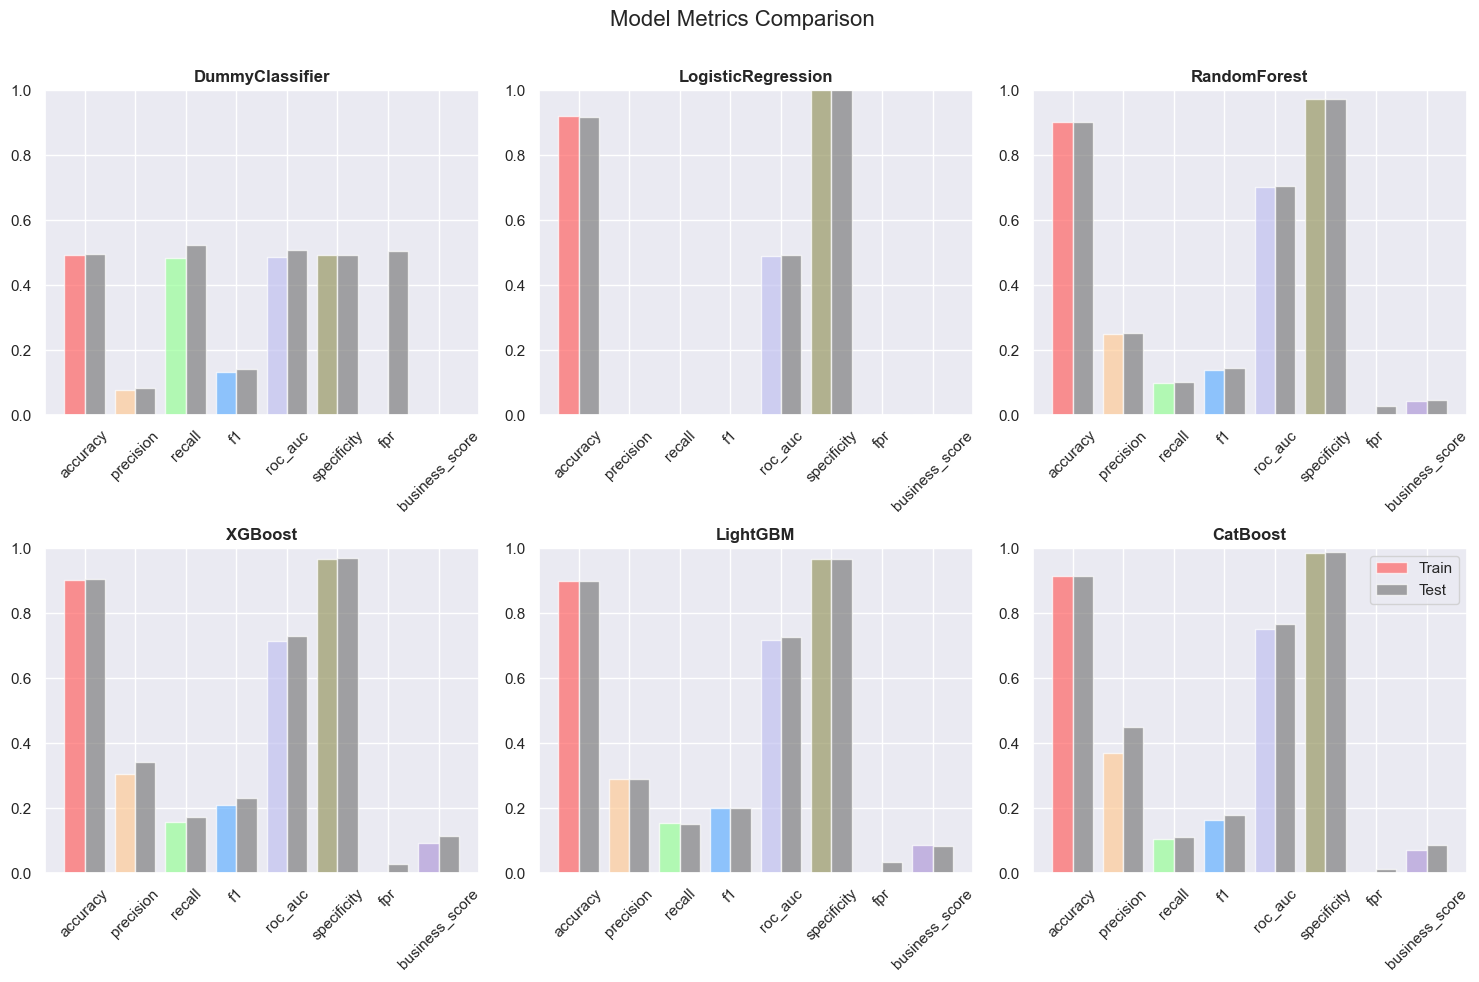

In [40]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'specificity', 'fpr', 'business_score']
plot_metrics(results_cv_tuned, results_test_tuned, metrics)

In [41]:
# Comparison between model before and after fine tuning

def plot_metrics_dual_per_model(model_name, train_results, test_results, train_results_ft, test_results_ft):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'specificity', 'fpr', 'business_score']
    
    # Define colors
    colors = {'Val': 'darkblue', 'Test': 'darkorange', 'Val-FT': 'darkblue', 'Test-FT': 'darkorange'}

    # Create a 2x4 grid of subplots
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.subplots_adjust(hspace=0.5, wspace=0.3)
    
    # Add a super title with the model's name
    fig.suptitle(model_name, fontsize=16)

    for i, metric in enumerate(metrics):
        ax = axes[i // 4, i % 4]
        data = [
            train_results.get(metric, 0),
            test_results.get(metric, 0),
            train_results_ft.get(metric, 0),
            test_results_ft.get(metric, 0),
        ]
        x_labels = ['Val', 'Test', 'Val-FT', 'Test-FT']

        ax.bar(x_labels, data, color=[colors[label] for label in x_labels])
        ax.set_ylabel(metric)
        ax.set_title(metric)

        # Rotate x-axis labels
        ax.set_xticklabels(x_labels, rotation=45)

        # Set y-axis limits to vary from 0 to 1
        ax.set_ylim(0, 1)

    plt.tight_layout()  # Set the layout tight
    plt.show()

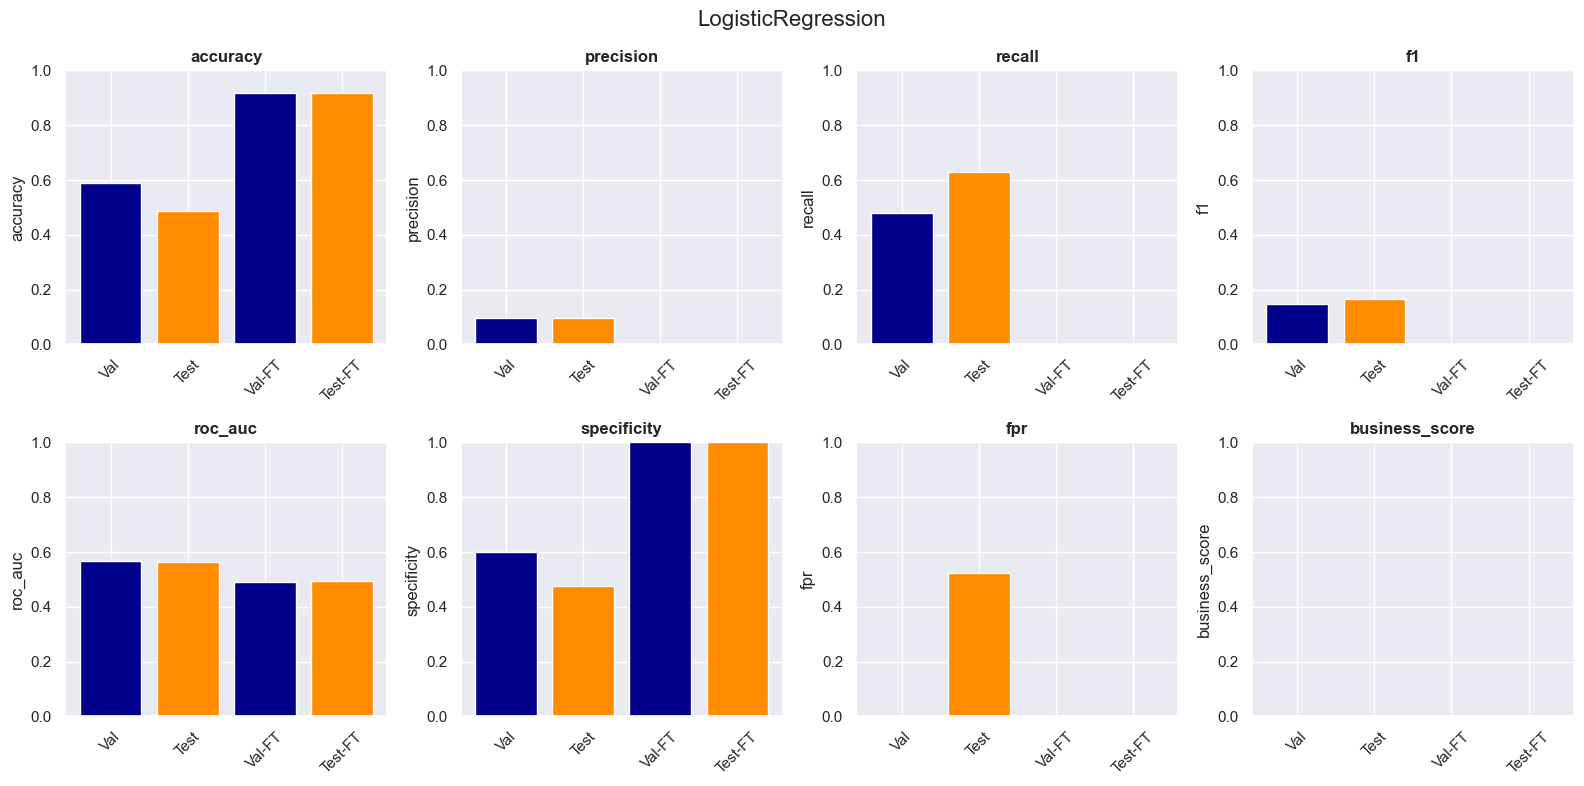

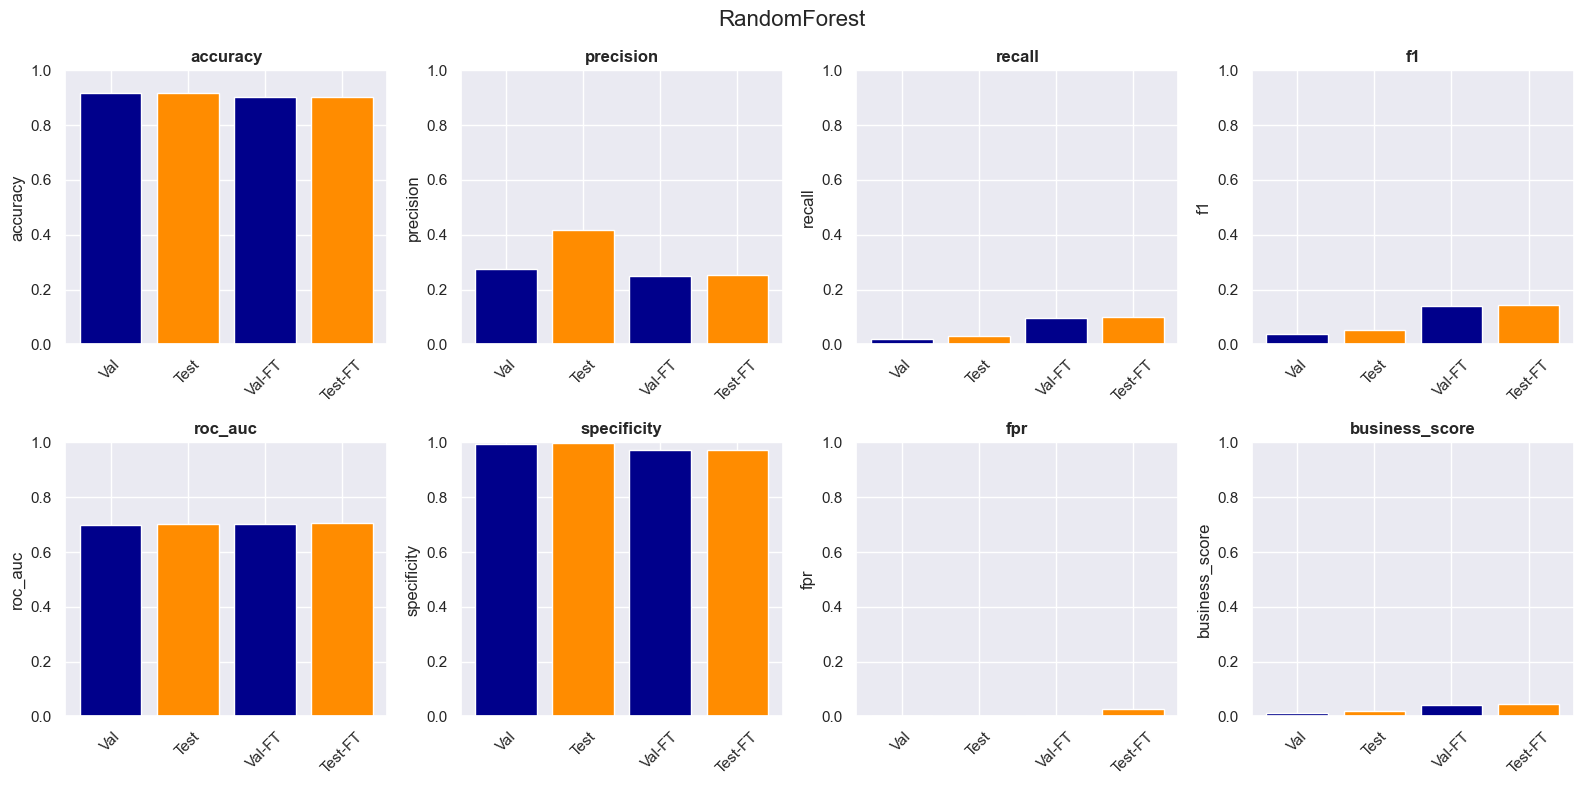

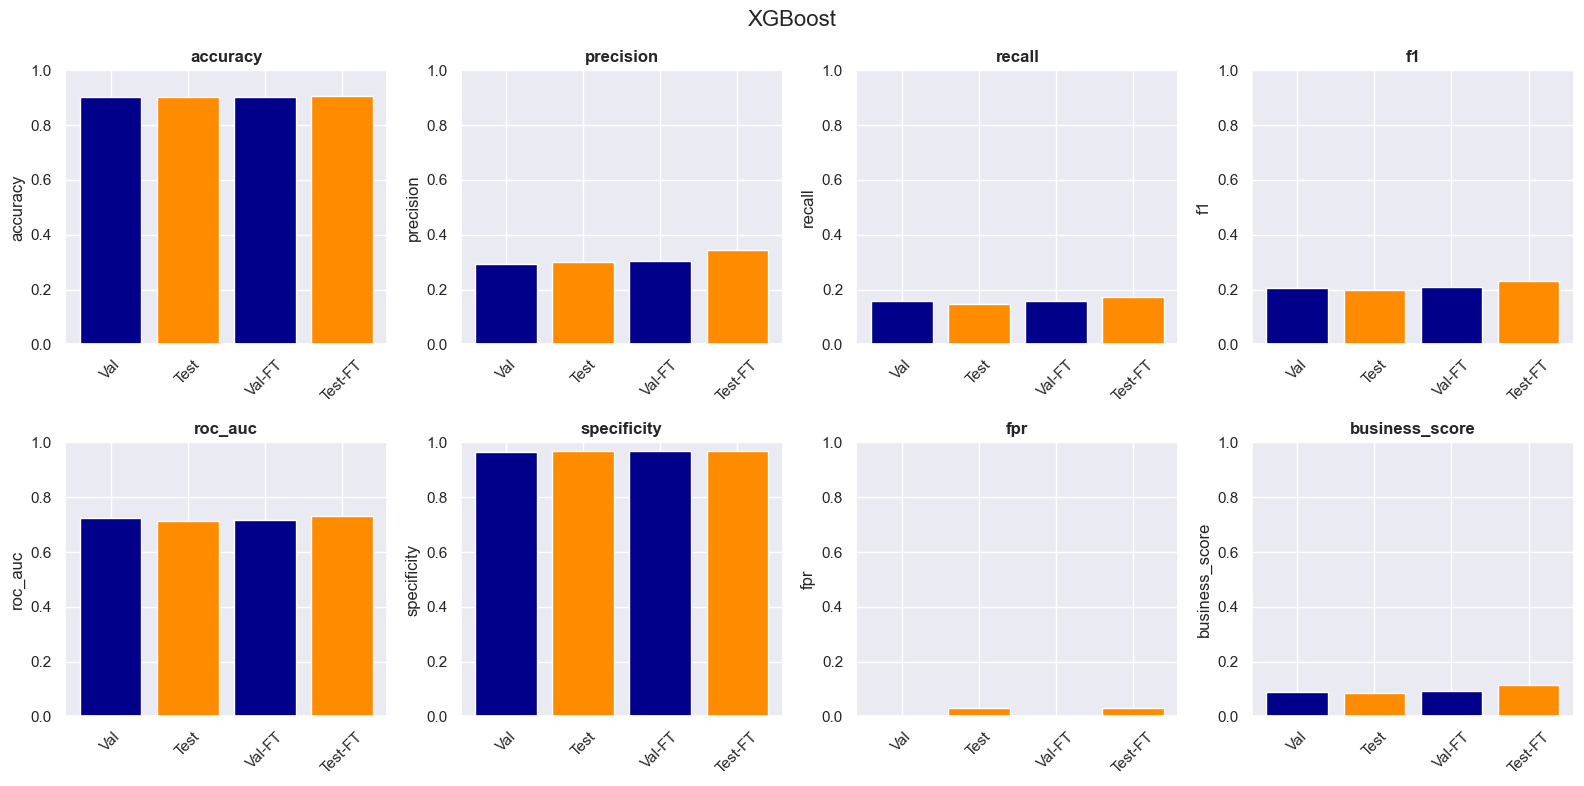

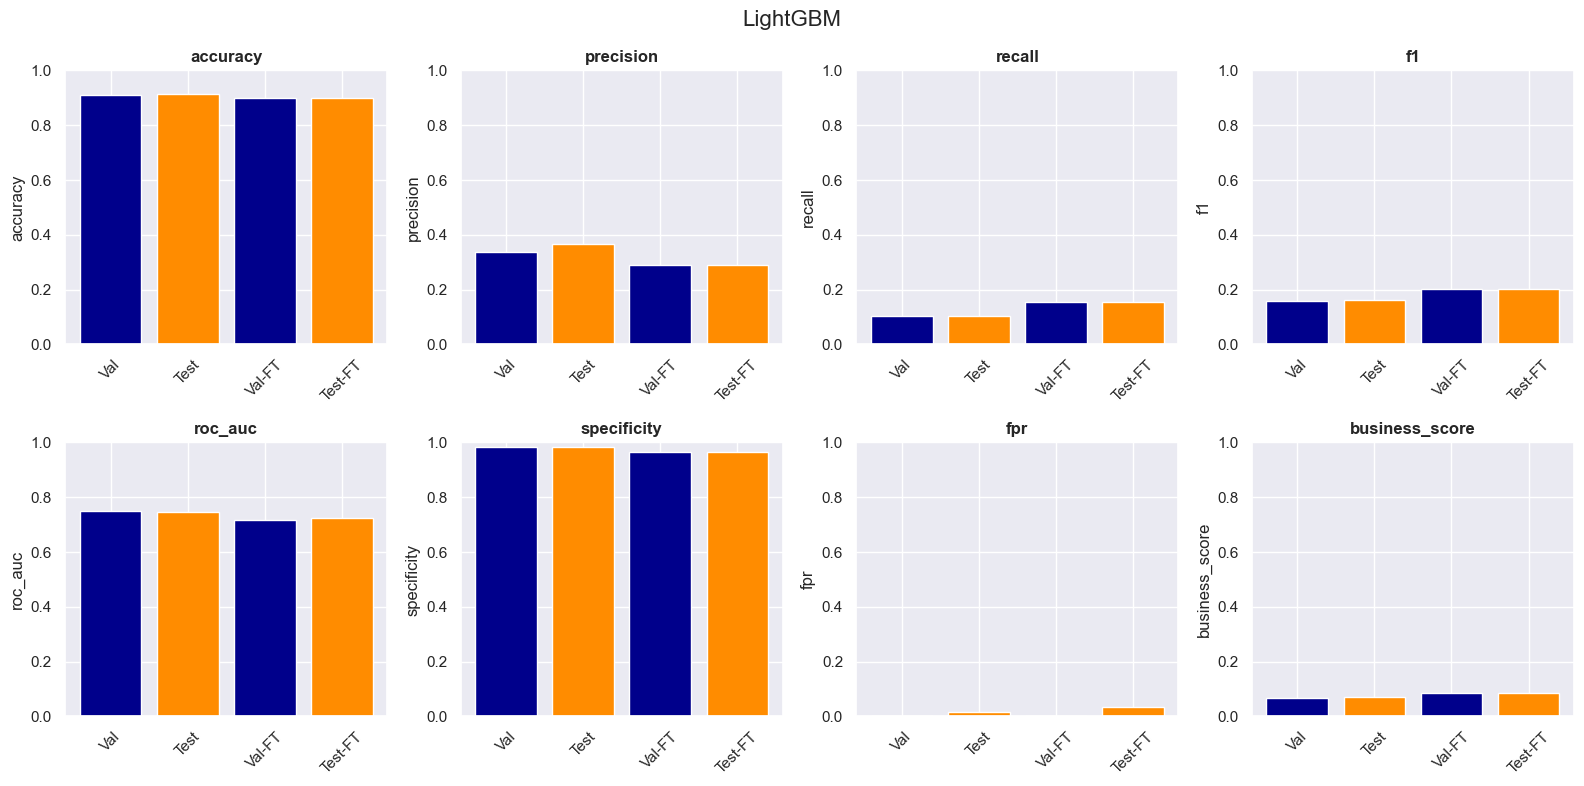

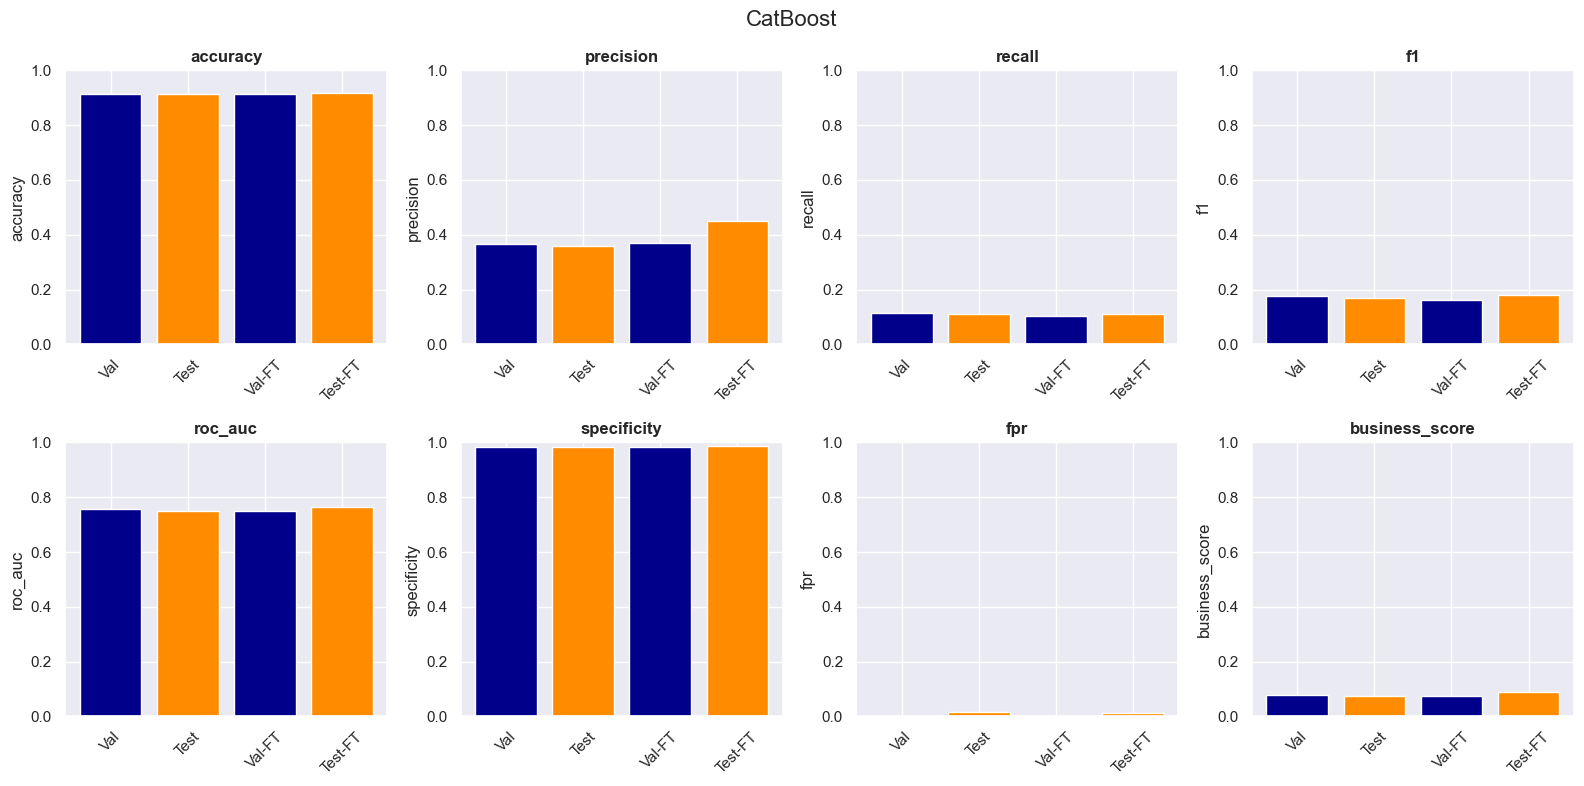

In [42]:
models = {'lr': 'LogisticRegression', 
          'rf': 'RandomForest', 
          'xgbc': 'XGBoost', 
          'lgbmc': 'LightGBM', 
          'cbc': 'CatBoost'}

for model, name in models.items():
    train_results = globals()[model + '_results_cv']
    test_results = globals()[model + '_results_test']
    train_results_ft = globals()[model + 't_results_cv']
    test_results_ft = globals()[model + 't_results_test']
    plot_metrics_dual_per_model(name, train_results, test_results, train_results_ft, test_results_ft)

XGBoost and LightGBM are the best models regarding Business score and Accuracy.
However, **LightGBM** was chosen because it takes a shorter time to train.

In [132]:
# Get best params of LigthGBM and fine tune around them + new hyper parameters

lgbmct_model.named_steps['classifier'].get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 200,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 0.9,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'device': 'cpu'}

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs
Fitting 5 folds for each of 120 candidates, totalling 600 fits
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Number of positive: 14468, number of negative: 14468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 98737
[LightGBM] [Info] Number of data points in the train set: 28936, number of used features: 492
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

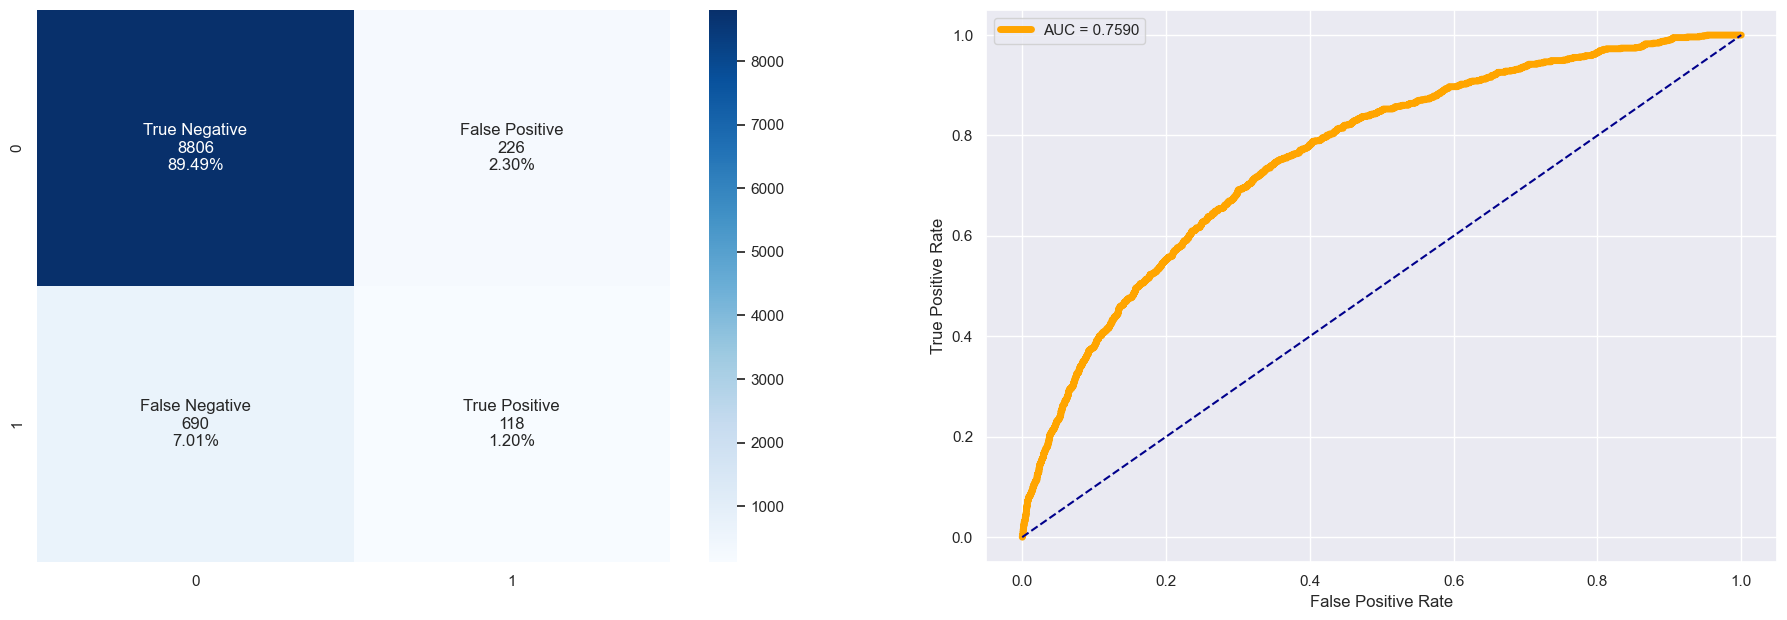

In [133]:
# Fine tune the best model around best params
%time
# Create LightGBM classifier
lgbmct = LGBMClassifier(random_state=RANDOM_STATE, device='cpu', n_jobs=-1)
lgbmct_name = 'LightGBM_fine_tuned_2'

# Set hyperparameter grid
param_grid = { 
    'classifier__n_estimators': [x for x in range(100, 350, 50)],
    'classifier__max_depth': [3, 4, 5, 6, 7, 8, 9],
    'classifier__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5], 
    'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0], 
    'classifier__num_leaves': [x for x in range(20, 51, 5)]
}

# Compute results and get fine-tuned model
lgbmct_model, lgbmct_results_cv, lgbmct_results_test = search_hyperparameters(lgbmct_name, lgbmct, param_grid=param_grid, cv=5, fast_train=0.2, n_iter=120)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 2.15 µs
[LightGBM] [Info] Number of positive: 72369, number of negative: 72369
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.168516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 116899
[LightGBM] [Info] Number of data points in the train set: 144738, number of used features: 515
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

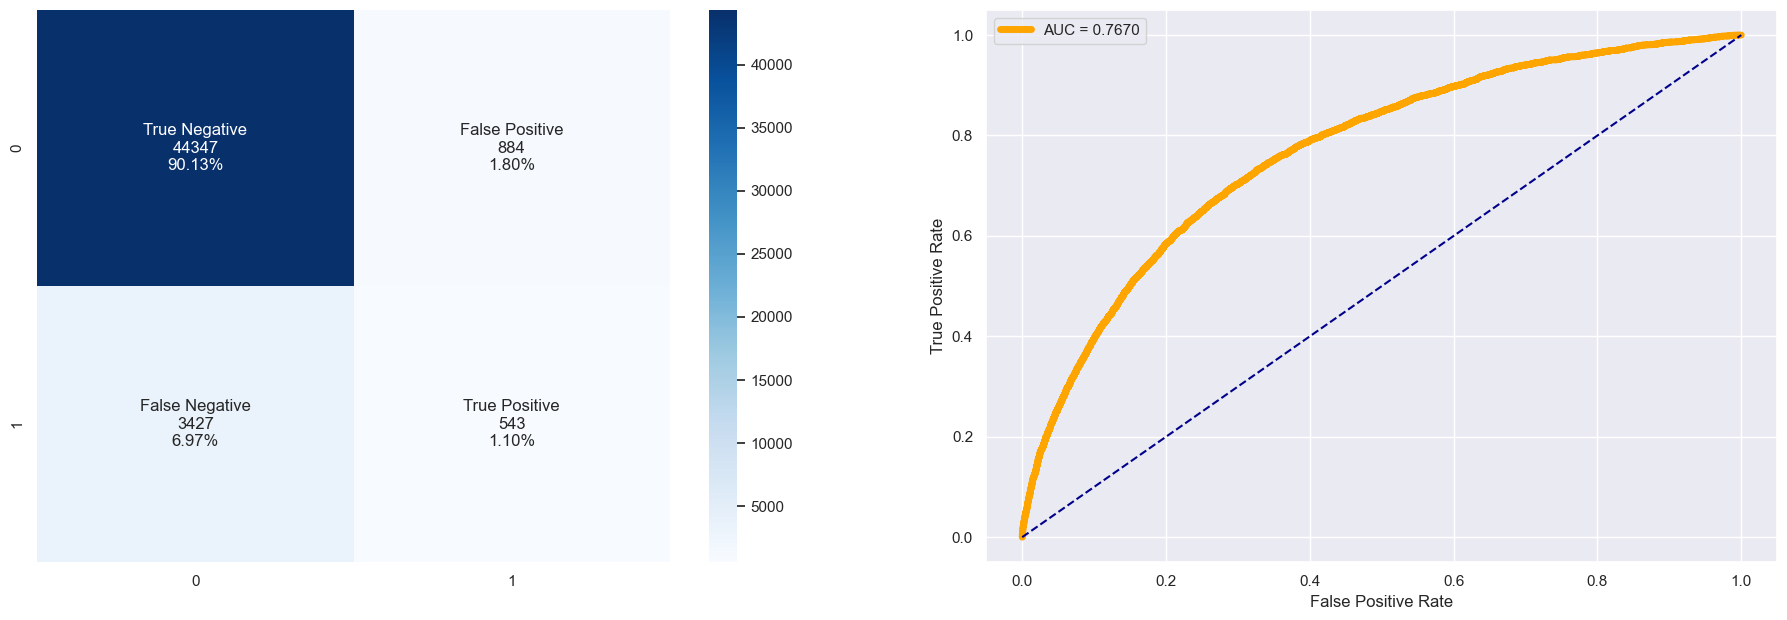

In [134]:
# Train the best model with the whole train dataset
%time
# Get the best params 
best_params = lgbmct_model.named_steps['classifier'].get_params()

# Create LightGBM classifier
lgbmc_final = LGBMClassifier(**best_params)
lgbmc_final_name = 'LightGBM_final'

# Compute results 
lgbmc_final_model, lgbmc_final_results_cv, lgbmc_final_results_test = train_model(lgbmc_final_name, lgbmc_final, cv=5)

In [135]:
lgbmc_final_results_cv

{'accuracy': 0.9122574243974318,
 'precision': 0.38785115254509595,
 'recall': 0.15012594458438286,
 'f1': 0.2163723852188572,
 'roc_auc': 0.7718894889484795,
 'specificity': 0.9791513378980099,
 'fpr': -0.020848662101990132,
 'business_score': 0.1069384016487291,
 'fit_time': 199.08946857452392,
 'execution_time': 202.79051113128662}

In [136]:
lgbmc_final_results_test

{'fit_time': 8.130118131637573,
 'accuracy': 0.9123798296782586,
 'precision': 0.3805185704274702,
 'recall': 0.13677581863979849,
 'f1': 0.20122290161200665,
 'roc_auc': 0.7669811953828729,
 'specificity': 0.9804558820278128,
 'fpr': 0.019544117972187216,
 'business_score': 0.09629035951454087}

#### Threshold selection

In [137]:
def threshold_selection(y_test, y_prob):
    thresholds = np.arange(0, 1, 0.001)
    scores = []
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        score = business_loss_func(y_test, y_pred)
        scores.append(score)
        
    scores = np.asarray(scores)
    ix = np.argmax(scores)
    
    best_threshold, best_score = (thresholds[ix], round(scores[ix], 3))
    
    print("Best results")
    print("- Best Threshold:\t", best_threshold)
    print("- Best Score:\t\t", best_score)
    print("\n")
    
    plt.subplots(1, figsize=(6, 5))
    plt.plot(thresholds, scores, lw=1)
    plt.axvline(best_threshold, ls="--", lw=1, c="r")
    plt.title("Threshold")
    plt.xlabel("proba threshold")
    plt.ylabel("Score performed")
    plt.show()
    
    return best_threshold

In [138]:
# Function to compute roc curve
def compute_roc_curve(y_test, y_pred_proba, model_name="Model", disp_best_th=False):
    # Compute metrics
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Create fig
    plt.figure()
    plt.title(model_name + ": ROC curve")

    # Display x=y
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')

    # Display ROC curve
    sns.lineplot(x=fpr, y=tpr, legend='brief', label="AUC = {:.3f}".format((auc)))

    if disp_best_th is True:

        # Compute best threshold
        o_tpr = tpr[np.argmax(tpr - fpr)]
        o_fpr = fpr[np.argmax(tpr - fpr)]
        o_threshold = thresholds[np.argmax(tpr - fpr)]

        # Display best threshold
        sns.scatterplot(x=[o_fpr], y=[o_tpr], legend='brief', label="Best threshold = {:.3f}".format(o_threshold))

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

    # Return AUC score
    return auc

In [139]:
# Function to display confusion matrix
def display_confusion_matrix(y_test, y_pred, model_name="Model"):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(model_name + ": Confusion matrix")
    plt.grid(visible=None)
    plt.show()

In [140]:
# Get proba predictions from xgbc model to be class 1 : repay failure
lgbmc_proba = lgbmc_final_model.predict_proba(x_test)[:,1]

Best results
- Best Threshold:	 0.274
- Best Score:		 0.212




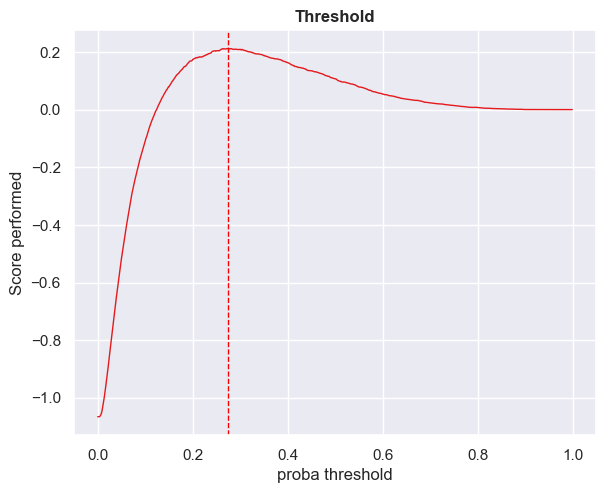

In [141]:
threshold = threshold_selection(y_test, lgbmc_proba)

The best prediction threshold is given by the point where the true positive rate and false positive rate are the lower. 
Here it gives us 0.274

Let's try different value of the prediction threshold : [0.5, 0.4, 0.3, 0.2, 0.1]

Printing results for threshold = 0.5
Business score = 0.10669712197350388


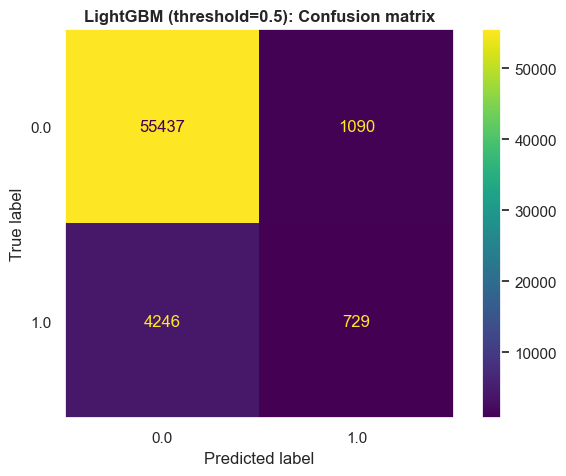

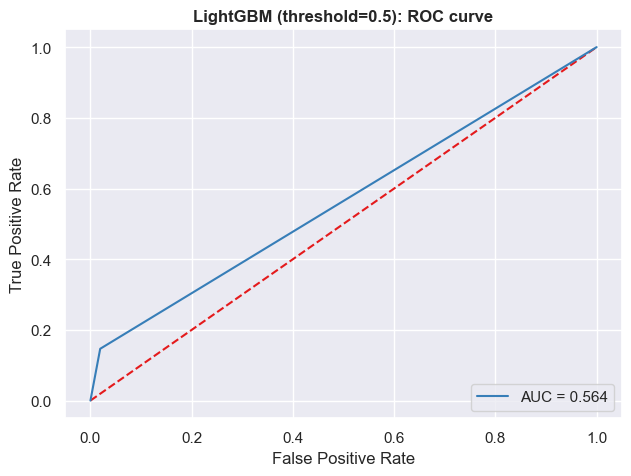

precision    recall  f1-score       support
0.0            0.928857  0.980717  0.954083  56527.000000
1.0            0.400770  0.146533  0.214601   4975.000000
accuracy       0.913239  0.913239  0.913239      0.913239
macro avg      0.664814  0.563625  0.584342  61502.000000
weighted avg   0.886140  0.913239  0.894265  61502.000000

Printing results for threshold = 0.3
Business score = 0.20849703060758337


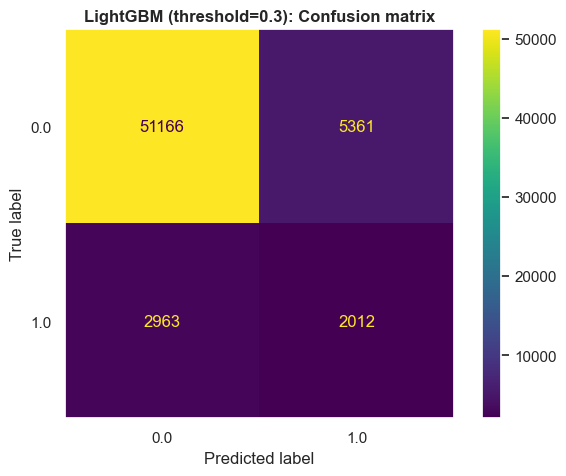

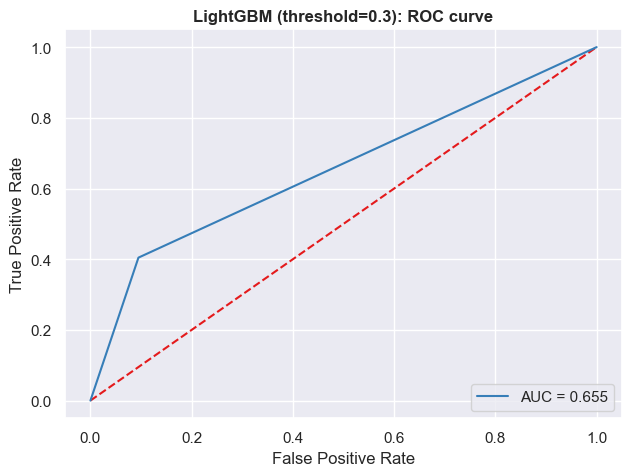

precision    recall  f1-score       support
0.0            0.945260  0.905160  0.924776  56527.000000
1.0            0.272888  0.404422  0.325883   4975.000000
accuracy       0.864655  0.864655  0.864655      0.864655
macro avg      0.609074  0.654791  0.625329  61502.000000
weighted avg   0.890871  0.864655  0.876330  61502.000000

Printing results for threshold = 0.274
Business score = 0.2117679305619004


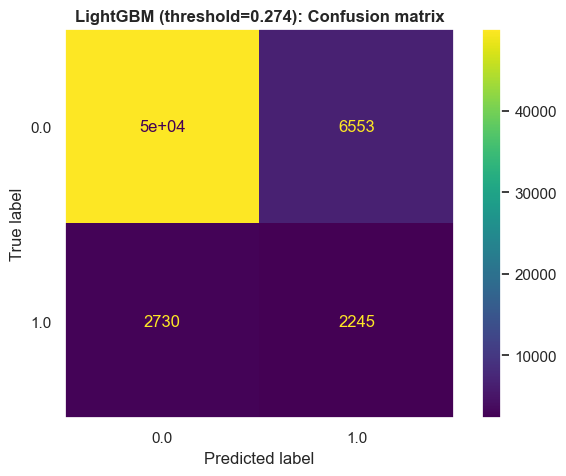

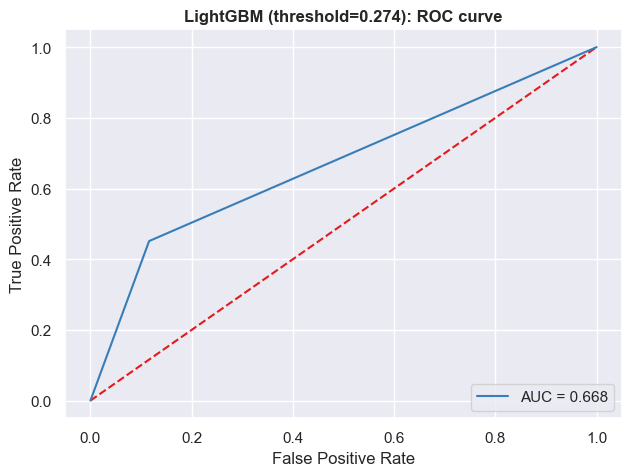

precision    recall  f1-score       support
0.0            0.948201  0.884073  0.915015  56527.000000
1.0            0.255172  0.451256  0.326000   4975.000000
accuracy       0.849062  0.849062  0.849062      0.849062
macro avg      0.601686  0.667665  0.620508  61502.000000
weighted avg   0.892141  0.849062  0.867369  61502.000000

Printing results for threshold = 0.2
Business score = 0.173796253997259


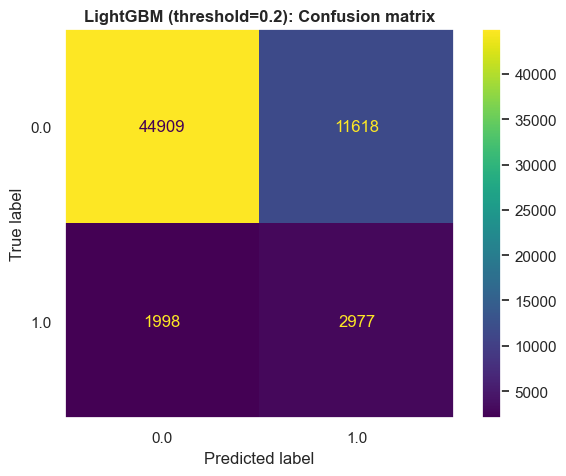

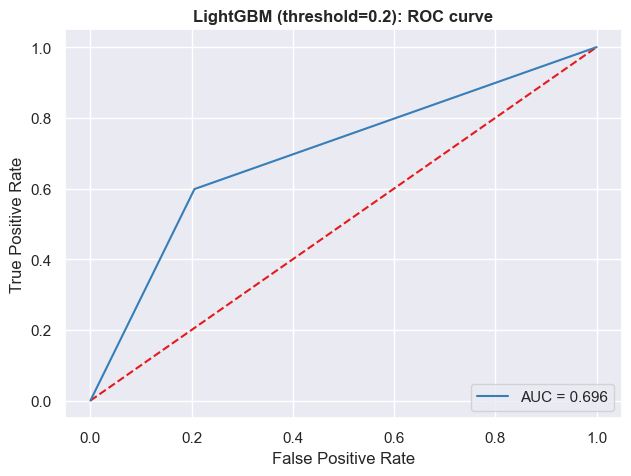

precision    recall  f1-score       support
0.0            0.957405  0.794470  0.868361  56527.000000
1.0            0.203974  0.598392  0.304241   4975.000000
accuracy       0.778609  0.778609  0.778609      0.778609
macro avg      0.580690  0.696431  0.586301  61502.000000
weighted avg   0.896459  0.778609  0.822728  61502.000000

In [142]:
for threshold in [0.5, 0.3, 0.274, 0.2]: 
    print(f'Printing results for threshold = {threshold}')
    lgbm_pred_std = lgbmc_proba >= threshold
    business_score = business_loss_func(y_test, lgbm_pred_std)
    print('Business score =', business_score)
    display_confusion_matrix(y_test, lgbm_pred_std, model_name=f'LightGBM (threshold={str(threshold)})')
    auc_score = compute_roc_curve(y_test, lgbm_pred_std, model_name=f'LightGBM (threshold={str(threshold)})')
    clf_report = pd.DataFrame(classification_report(y_test, lgbm_pred_std, output_dict=True)).transpose()
    display(clf_report)


#### Explainer / Feature importance

##### Global feature importance

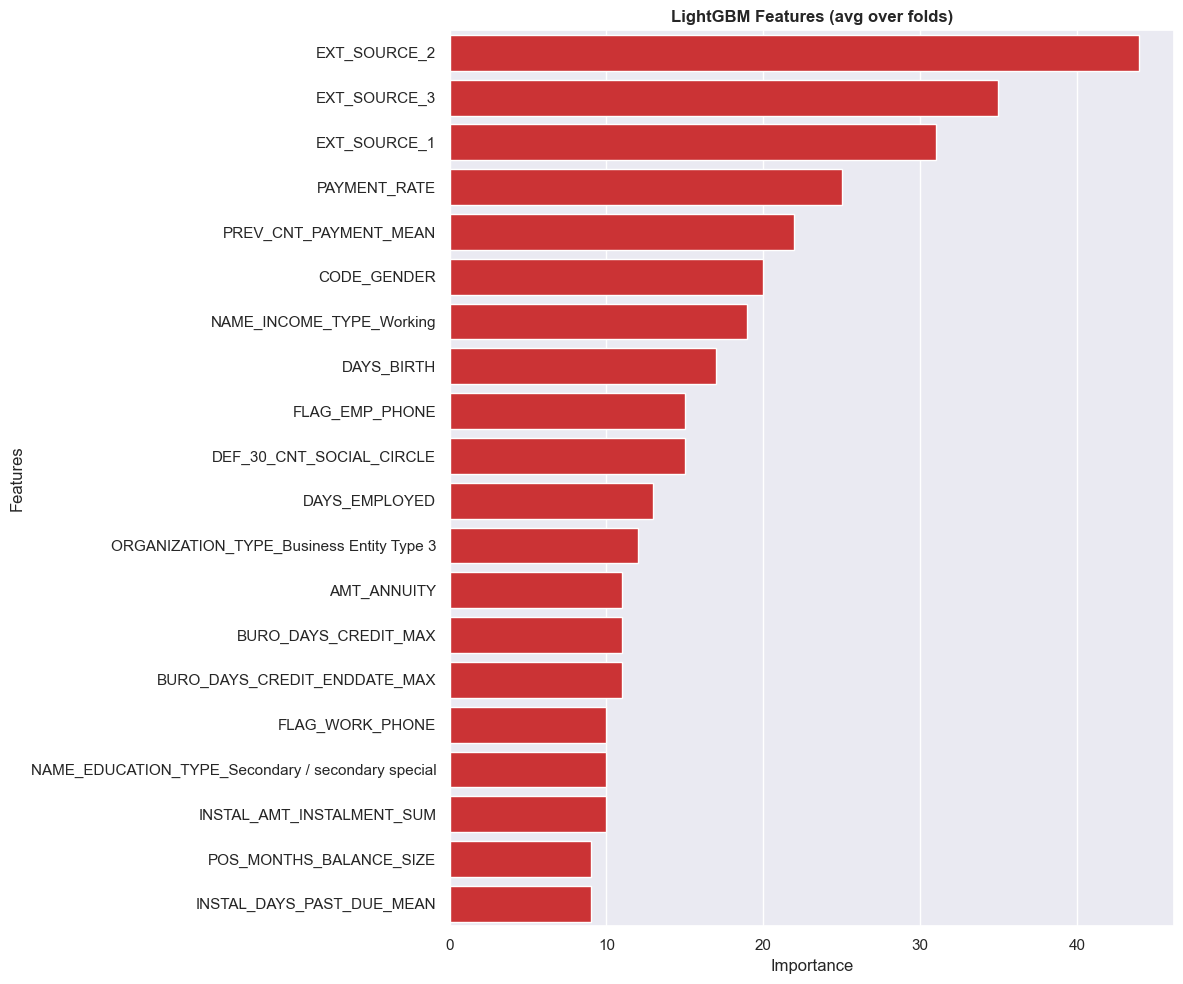

In [143]:
feature_importance_df_ = pd.DataFrame({'importance': lgbmc_final_model.steps[2][1].feature_importances_, 
                                       'feature': x_train.columns})

cols = feature_importance_df_[['feature', 'importance']].groupby('feature').mean().sort_values(by='importance', ascending=False)[:20].index
best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
plt.figure(figsize=(12, 10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("LightGBM Features (avg over folds)")
plt.tight_layout()
plt.show()

##### Local feature importance (SHAP)

In [144]:
shap_explainer = shap.TreeExplainer(lgbmc_final_model.steps[2][1])
shap_values = shap_explainer.shap_values(x_test)

In [145]:
idx = 1000

shap.initjs()
shap.force_plot(shap_explainer.expected_value[0], 
                shap_values[0][idx, :], 
                x_train.iloc[idx, :])

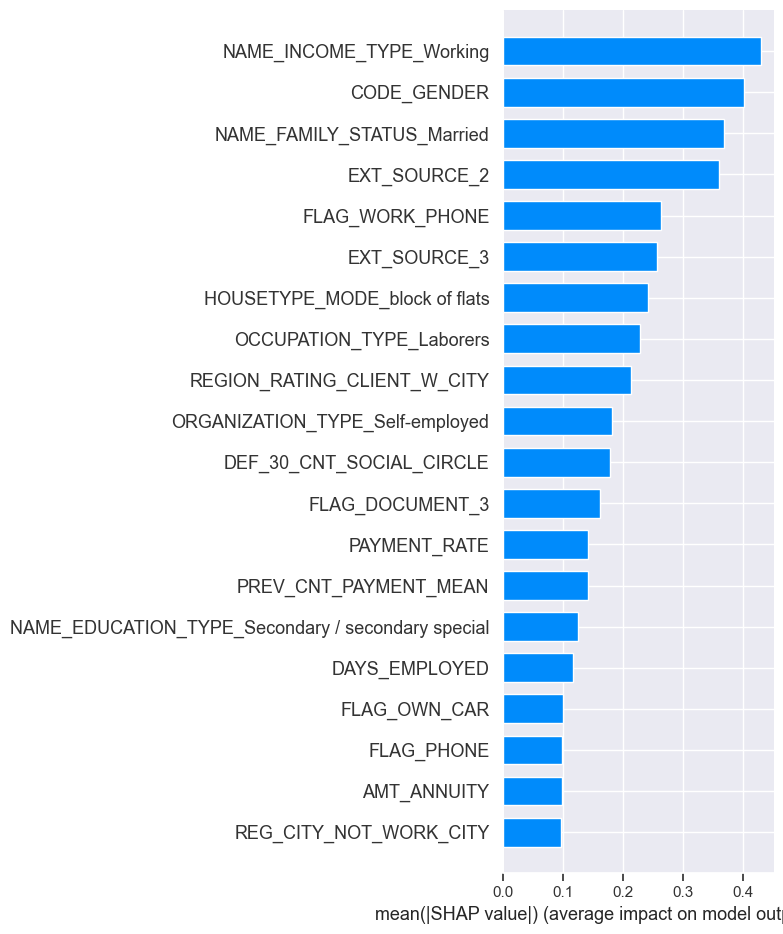

In [107]:
shap.summary_plot(shap_values[0], x_test, plot_type='bar')

#### Export

In [146]:
# Final model

filename = 'models/lightgbm_classifier.pkl'
pickle.dump(lgbmc_final_model.steps[2][1], open(filename, 'wb'))

In [147]:
# SHAP explainer

filename = 'models/lightgbm_shap_explainer.pkl'
pickle.dump(shap_explainer, open(filename, 'wb'))